In [4]:
!curl -L -o dataset.h5ad https://datasets.cellxgene.cziscience.com/5f462e5e-0e6e-45ff-84e5-d18fea2ee7d6.h5ad


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0  403M    0  300k    0     0   215k      0  0:31:55  0:00:01  0:31:54  215k
  0  403M    0 1626k    0     0   672k      0  0:10:13  0:00:02  0:10:11  672k
  0  403M    0 3752k    0     0  1106k      0  0:06:13  0:00:03  0:06:10 1106k
  1  403M    1 6736k    0     0  1530k      0  0:04:29  0:00:04  0:04:25 1531k
  2  403M    2 10.3M    0     0  1970k      0  0:03:29  0:00:05  0:03:24 2349k
  3  403M    3 14.8M    0     0  2377k      0  0:02:53  0:00:06  0:02:47 2979k
  5  403M    5 20.2M    0     0  2779k      0  0:02:28  0:00:07  0:02:21 3792k
  6  403M    6 26.4M    0     0  3226k      0  0:02:07  0:00:08  0:01:59 4665k
  8  403M    8 34.3M    0     0  3746k      0  0:01

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
from anndata import AnnData
import partipy as pt


# Verbosity parameter shows amount of
# logging you will see during functions' execution
sc.settings.verbosity = 3

# Reading of the dataset

adata = sc.read_h5ad("dataset.h5ad")
adata


AnnData object with n_obs × n_vars = 57019 × 24349
    obs: 'donor_id', 'Time', 'donor_time', 'leiden', 'sample', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'author_cell_type', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'n.cells', 'gene_symbols', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'cell_type_ontology_term_id_colors', 'citation', 'default_embedding', 'organism', 'organism_ontology_term_id', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

In [3]:
X = adata.X

X = X.toarray()

print("Shape:", X.shape)
print("Mean:", X.mean())
print("Median:", np.median(X))
print("Std:", X.std())
print("Min:", X.min())
print("Max:", X.max())


Shape: (57019, 24349)
Mean: 0.2281979
Median: 0.0
Std: 6.083767
Min: 0.0
Max: 21618.004


In [4]:
obs_keep = [
    "donor_id",
    "sample",
    "tissue",
    "tissue_type",
    "cell_type",
    "author_cell_type",
    "sex",
    "development_stage",
    "disease",
    "Time",
    "donor_time"
]

var_keep = [
    "gene_symbols",
    "feature_name",
    "feature_biotype",
    "feature_length"
]

obs_keep = [c for c in obs_keep if c in adata.obs.columns]

obs = adata.obs[obs_keep].copy()

var_keep = [c for c in var_keep if c in adata.var.columns]

var = adata.var[var_keep].copy()

adata_new = AnnData(
    X=adata.X,   # лучше использовать исходное adata.X
    obs=obs,
    var=var
)


adata_new



AnnData object with n_obs × n_vars = 57019 × 24349
    obs: 'donor_id', 'sample', 'tissue', 'tissue_type', 'cell_type', 'author_cell_type', 'sex', 'development_stage', 'disease', 'Time', 'donor_time'
    var: 'gene_symbols', 'feature_name', 'feature_biotype', 'feature_length'

In [107]:
# создаём словарь ENSG -> gene_symbol
gene_map = (
    adata_new.var
    .reset_index()
    .set_index("index")["gene_symbols"]
    .dropna()
    .to_dict()
)

# заменяем имена в индексе var
adata_new.var.index = adata_new.var.index.to_series().replace(gene_map)

adata_new.var


gene_symbols     feature_name feature_biotype feature_length  \
RP11-34P13.8  RP11-34P13.8  ENSG00000239945            gene           1319   
FO538757.3      FO538757.3         DDX11L17            gene            570   
FO538757.2      FO538757.2           WASH9P            gene           1397   
AP006222.2      AP006222.2  ENSG00000228463            gene            457   
RP4-669L17.2  RP4-669L17.2  ENSG00000236601            gene            620   
...                    ...              ...             ...            ...   
AL354822.1      AL354822.1  ENSG00000278384            gene           3027   
AC004556.1      AC004556.1  ENSG00000276345            gene            740   
AC233755.2      AC233755.2  ENSG00000277856            gene            294   
AC233755.1      AC233755.1  ENSG00000275063            gene            351   
AC240274.1      AC240274.1  ENSG00000271254            gene           2922   

                 mt  n_cells_by_counts  mean_counts  pct_dropout_by_counts  \
RP11-34P13.8  False                  3     0.000053              99.994739   
FO538757.3    False                  3     0.000053              99.994739   
FO538757.2    False               6163     0.125046              89.191322   
AP006222.2    False               5917     0.137375              89.622757   
RP4-669L17.2  False                  3     0.000053              99.994739   
...             ...                ...          ...                    ...   
AL354822.1    False                356     0.006384              99.375647   
AC004556.1    False                317     0.005560              99.444045   
AC233755.2    False                 11     0.000684              99.980708   
AC233755.1    False                 23     0.001140              99.959663   
AC240274.1    False                609     0.011259              98.931935   

              total_counts  
RP11-34P13.8           3.0  
FO538757.3             3.0  
FO538757.2          7130.0  
AP006222.2          7833.0  
RP4-669L17.2           3.0  
...                    ...  
AL354822.1           364.0  
AC004556.1           317.0  
AC233755.2            39.0  
AC233755.1            65.0  
AC240274.1           642.0  

[24349 rows x 9 columns]

In [108]:
adata_new.var["mt"] = adata_new.var_names.str.upper().str.startswith("MT-")

sc.pp.calculate_qc_metrics(
    adata_new,
    qc_vars=["mt"],
    percent_top=None,
    inplace=True,
    log1p=False,
)
adata_new.obs["pct_counts_mt"].describe()

count    57019.000000
mean         3.892969
std          2.125316
min          0.000000
25%          2.323794
50%          3.327922
75%          5.066912
max         10.382514
Name: pct_counts_mt, dtype: float64

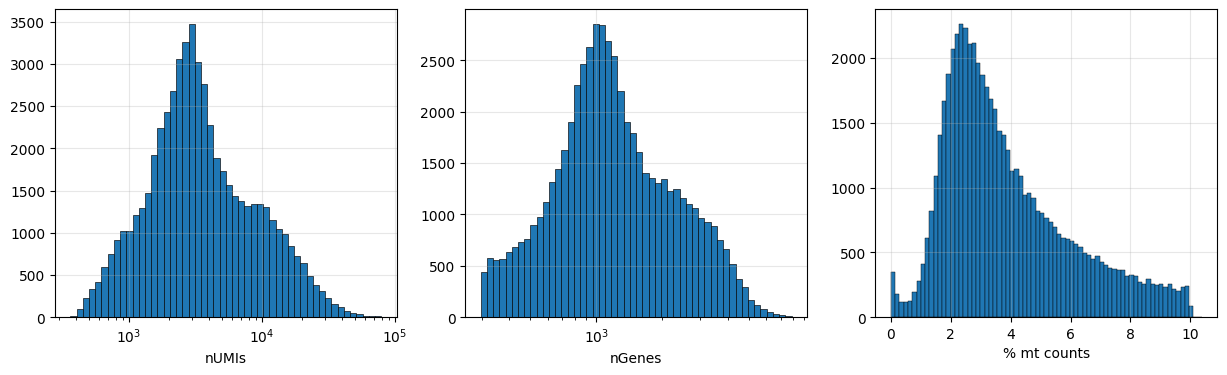

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

sns.histplot(adata_new.obs.total_counts, log_scale=True, alpha=1, bins=50, edgecolor="black", ax=axes[0])
axes[0].set_ylabel("")
axes[0].set_xlabel("nUMIs")
axes[0].grid(alpha=0.3)

sns.histplot(adata_new.obs.n_genes_by_counts, log_scale=True, alpha=1, bins=50, edgecolor="black", ax=axes[1])
axes[1].set_ylabel("")
axes[1].set_xlabel("nGenes")
axes[1].grid(alpha=0.3)

sns.histplot(adata_new.obs.pct_counts_mt, alpha=1, edgecolor="black", ax=axes[2])
axes[2].set_ylabel("")
axes[2].set_xlabel("% mt counts")
axes[2].grid(alpha=0.3)

In [7]:
adata_clear = adata_new[
    (adata_new.obs["total_counts"] > 500) &
    (adata_new.obs["total_counts"] < 40000) &
    (adata_new.obs["n_genes_by_counts"] < 6000)
].copy()


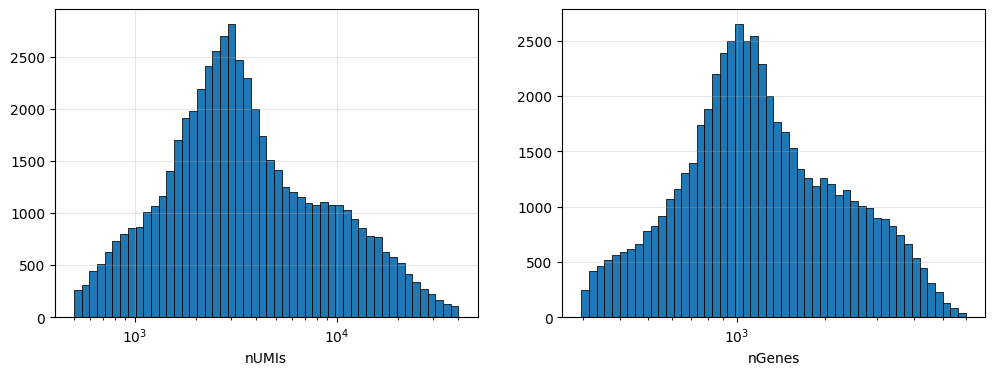

In [8]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))

sns.histplot(adata_clear.obs.total_counts, log_scale=True, alpha=1, bins=50, edgecolor="black", ax=axes[0])
axes[0].set_ylabel("")
axes[0].set_xlabel("nUMIs")
axes[0].grid(alpha=0.3)

sns.histplot(adata_clear.obs.n_genes_by_counts, log_scale=True, alpha=1, bins=50, edgecolor="black", ax=axes[1])
axes[1].set_ylabel("")
axes[1].set_xlabel("nGenes")
axes[1].grid(alpha=0.3)

In [ ]:
adata_clear.write("adata_raw_clean.h5ad")



In [114]:
print("Shape:", X.shape)
print("Shape:", adata_clear.shape)

Shape: (57019, 24349)
Shape: (56449, 3000)


In [10]:

adata_clear.raw = adata_clear.copy()
print(adata_clear.n_obs, adata_clear.n_vars)


sc.pp.scrublet(adata_clear, batch_key="donor_id")


56449 24349
Running Scrublet
filtered out 4379 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
    using data matrix X directly
Automatically set threshold at doublet score = 0.57
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 11.9%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 1.0%
filtered out 3857 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float v

In [11]:
adata.obs

donor_id Time donor_time leiden  \
AAACCTGGTTGTGGCC-1-HCATisStab7509734     343B   0h    343B_0h     10   
AAACGGGAGAAGGGTA-1-HCATisStab7509734     343B   0h    343B_0h     10   
AAACGGGCACCAGCAC-1-HCATisStab7509734     343B   0h    343B_0h     17   
AAACGGGCACGGACAA-1-HCATisStab7509734     343B   0h    343B_0h      3   
AAACGGGCACTCTGTC-1-HCATisStab7509734     343B   0h    343B_0h     10   
...                                       ...  ...        ...    ...   
TTTGTCACATAGAAAC-1-HCATisStab7747200     390C  72h   390C_72h      1   
TTTGTCAGTCGGATCC-1-HCATisStab7747200     390C  72h   390C_72h      1   
TTTGTCATCAAACAAG-1-HCATisStab7747200     390C  72h   390C_72h      8   
TTTGTCATCATGGTCA-1-HCATisStab7747200     390C  72h   390C_72h      8   
TTTGTCATCTTCTGGC-1-HCATisStab7747200     390C  72h   390C_72h      8   

                                                 sample  \
AAACCTGGTTGTGGCC-1-HCATisStab7509734  HCATisStab7509734   
AAACGGGAGAAGGGTA-1-HCATisStab7509734  HCATisStab7509734   
AAACGGGCACCAGCAC-1-HCATisStab7509734  HCATisStab7509734   
AAACGGGCACGGACAA-1-HCATisStab7509734  HCATisStab7509734   
AAACGGGCACTCTGTC-1-HCATisStab7509734  HCATisStab7509734   
...                                                 ...   
TTTGTCACATAGAAAC-1-HCATisStab7747200  HCATisStab7747200   
TTTGTCAGTCGGATCC-1-HCATisStab7747200  HCATisStab7747200   
TTTGTCATCAAACAAG-1-HCATisStab7747200  HCATisStab7747200   
TTTGTCATCATGGTCA-1-HCATisStab7747200  HCATisStab7747200   
TTTGTCATCTTCTGGC-1-HCATisStab7747200  HCATisStab7747200   

                                     assay_ontology_term_id  \
AAACCTGGTTGTGGCC-1-HCATisStab7509734            EFO:0009899   
AAACGGGAGAAGGGTA-1-HCATisStab7509734            EFO:0009899   
AAACGGGCACCAGCAC-1-HCATisStab7509734            EFO:0009899   
AAACGGGCACGGACAA-1-HCATisStab7509734            EFO:0009899   
AAACGGGCACTCTGTC-1-HCATisStab7509734            EFO:0009899   
...                                                     ...   
TTTGTCACATAGAAAC-1-HCATisStab7747200            EFO:0009899   
TTTGTCAGTCGGATCC-1-HCATisStab7747200            EFO:0009899   
TTTGTCATCAAACAAG-1-HCATisStab7747200            EFO:0009899   
TTTGTCATCATGGTCA-1-HCATisStab7747200            EFO:0009899   
TTTGTCATCTTCTGGC-1-HCATisStab7747200            EFO:0009899   

                                     cell_type_ontology_term_id  \
AAACCTGGTTGTGGCC-1-HCATisStab7509734                 CL:0000071   
AAACGGGAGAAGGGTA-1-HCATisStab7509734                 CL:0000071   
AAACGGGCACCAGCAC-1-HCATisStab7509734                 CL:0000322   
AAACGGGCACGGACAA-1-HCATisStab7509734                 CL:0000322   
AAACGGGCACTCTGTC-1-HCATisStab7509734                 CL:0000071   
...                                                         ...   
TTTGTCACATAGAAAC-1-HCATisStab7747200                 CL:0000623   
TTTGTCAGTCGGATCC-1-HCATisStab7747200                 CL:0000623   
TTTGTCATCAAACAAG-1-HCATisStab7747200                 CL:0000576   
TTTGTCATCATGGTCA-1-HCATisStab7747200                 CL:0000576   
TTTGTCATCTTCTGGC-1-HCATisStab7747200                 CL:0000576   

                                     development_stage_ontology_term_id  \
AAACCTGGTTGTGGCC-1-HCATisStab7509734                     HsapDv:0000242   
AAACGGGAGAAGGGTA-1-HCATisStab7509734                     HsapDv:0000242   
AAACGGGCACCAGCAC-1-HCATisStab7509734                     HsapDv:0000242   
AAACGGGCACGGACAA-1-HCATisStab7509734                     HsapDv:0000242   
AAACGGGCACTCTGTC-1-HCATisStab7509734                     HsapDv:0000242   
...                                                                 ...   
TTTGTCACATAGAAAC-1-HCATisStab7747200                     HsapDv:0000241   
TTTGTCAGTCGGATCC-1-HCATisStab7747200                     HsapDv:0000241   
TTTGTCATCAAACAAG-1-HCATisStab7747200                     HsapDv:0000241   
TTTGTCATCATGGTCA-1-HCATisStab7747200                     HsapDv:0000241   
TTTGTCATCTTCTGGC-1-HCATisStab7747200                     HsapDv:0000241   



In [12]:
sc.pp.filter_genes(adata_clear, min_cells=10)


filtered out 2782 genes that are detected in less than 10 cells


In [13]:
sc.pp.normalize_total(adata_clear, target_sum=1e4)
sc.pp.log1p(adata_clear)


normalizing counts per cell
    finished (0:00:00)


In [14]:
sc.pp.highly_variable_genes(adata_clear, n_top_genes=3000, batch_key="donor_id")
adata_clear = adata_clear[:, adata_clear.var['highly_variable']]



extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [15]:
sc.pp.scale(adata_clear, max_value=10)
sc.pp.pca(adata_clear, n_comps=30)


c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\scanpy\preprocessing\_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\functools.py:934: UserWarning: zero-centering a sparse array/matrix densifies it.


computing PCA
    with n_comps=30
    finished (0:00:09)


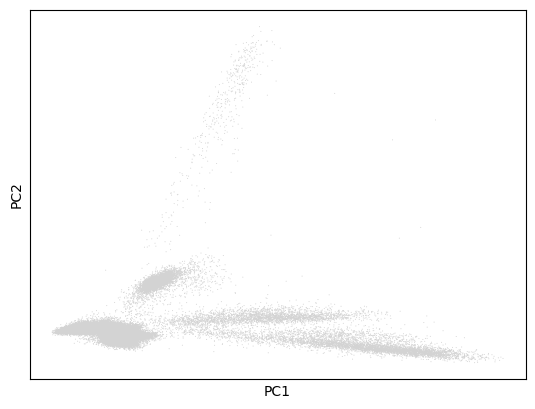

In [16]:
adata_clear.layers["z_scaled"]= sc.pp.scale(adata_clear.X, max_value=10, copy=True)
sc.pl.pca_scatter(adata_clear)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:09)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:42)


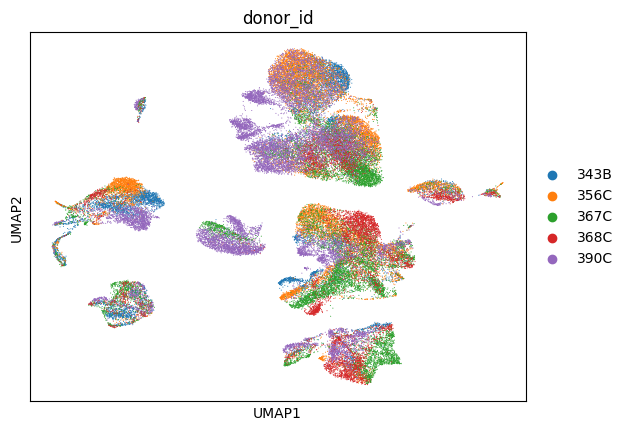

In [17]:
adata_nocorr = adata_clear.copy()

sc.pp.neighbors(adata_nocorr)
sc.tl.umap(adata_nocorr)

sc.pl.umap(adata_nocorr, color="donor_id")



running Leiden clustering


C:\Users\1\AppData\Local\Temp\ipykernel_11780\820519875.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.


    finished: found 30 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:06)


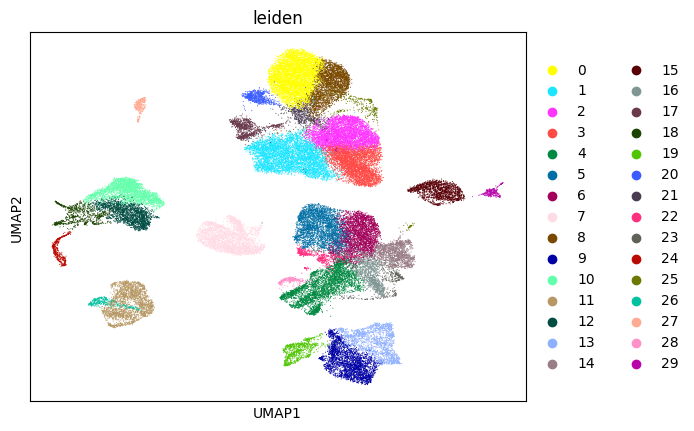

In [18]:
sc.tl.leiden(adata_nocorr)
sc.pl.umap(adata_nocorr, color="leiden")

C:\Users\1\AppData\Local\Temp\ipykernel_11780\2574327039.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


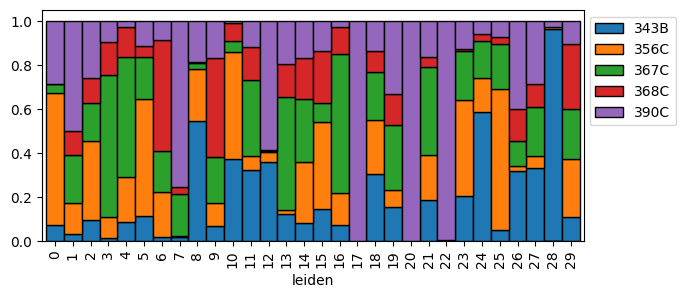

In [19]:
df = adata_nocorr.obs.groupby(["leiden", "donor_id"]).size().unstack().T
df = df / df.sum(axis=0)

fig, ax = plt.subplots(figsize=(7, 3))
df.T.plot(kind="bar", stacked=True, width=1, edgecolor="black", ax=ax)
ax.legend(loc=(1.01, 0.5))

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:01:11)


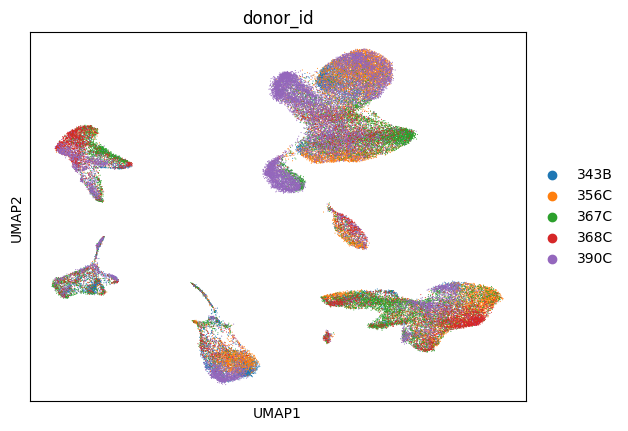

In [20]:
import bbknn

adata_bbknn = adata_clear.copy()
bbknn.bbknn(adata_bbknn, batch_key="donor_id")
sc.tl.umap(adata_bbknn)

sc.pl.umap(adata_bbknn, color="donor_id")

running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:09)


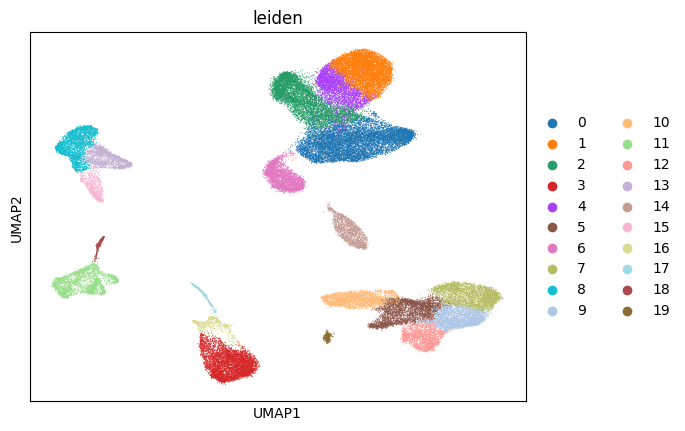

In [21]:
sc.tl.leiden(adata_bbknn)
sc.pl.umap(adata_bbknn, color="leiden")

C:\Users\1\AppData\Local\Temp\ipykernel_11780\3349944857.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


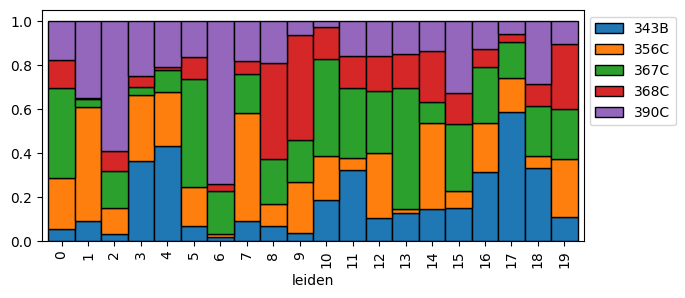

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

df = adata_bbknn.obs.groupby(["leiden", "donor_id"]).size().unstack().T
df = df / df.sum(axis=0)

fig, ax = plt.subplots(figsize=(7, 3))
df.T.plot(kind="bar", stacked=True, width=1, edgecolor="black", ax=ax)
ax.legend(loc=(1.01, 0.5))

In [23]:
# Harmony
import scanpy.external as sce

adata_harmony = adata_clear.copy()

sce.pp.harmony_integrate(adata_harmony, key="donor_id", max_iter_harmony=30)
sc.pp.neighbors(adata_harmony, use_rep="X_pca_harmony")
sc.tl.umap(adata_harmony)

2025-12-17 09:13:50,594 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

2025-12-17 09:14:00,060 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-12-17 09:14:00,327 - harmonypy - INFO - Iteration 1 of 30
2025-12-17 09:14:18,006 - harmonypy - INFO - Iteration 2 of 30
2025-12-17 09:14:35,370 - harmonypy - INFO - Iteration 3 of 30
2025-12-17 09:14:51,065 - harmonypy - INFO - Converged after 3 iterations


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:35)


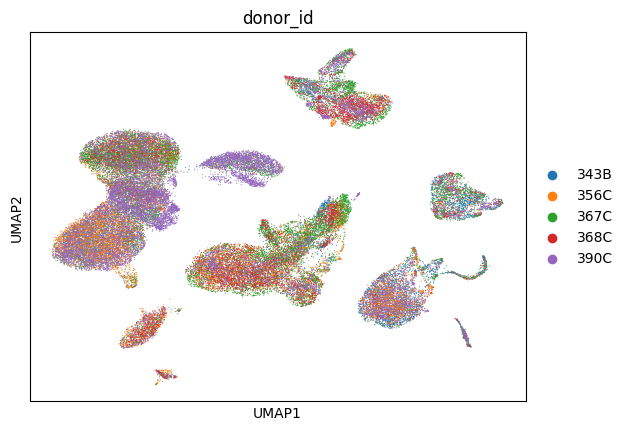

In [24]:
sc.pl.umap(adata_harmony, color="donor_id")

running Leiden clustering
    finished: found 25 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:09)


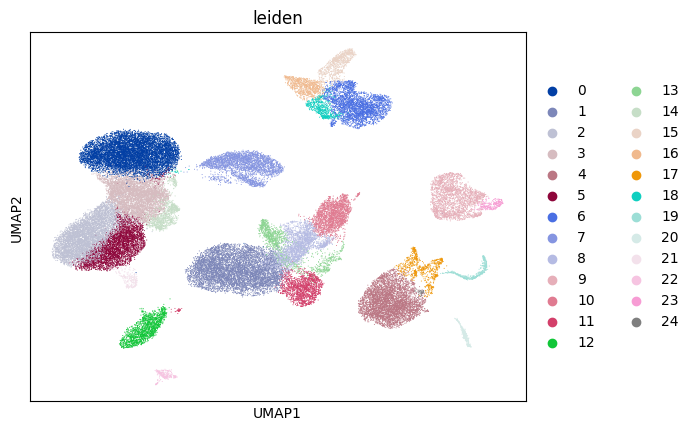

In [25]:
sc.tl.leiden(adata_harmony)
sc.pl.umap(adata_harmony, color="leiden")

C:\Users\1\AppData\Local\Temp\ipykernel_11780\3858766815.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


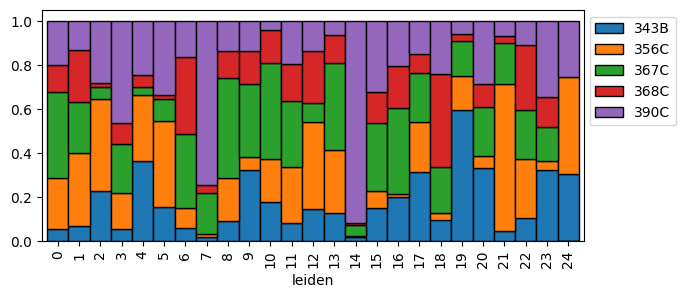

In [26]:
df = adata_harmony.obs.groupby(["leiden", "donor_id"]).size().unstack().T
df = df / df.sum(axis=0)

fig, ax = plt.subplots(figsize=(7, 3))
df.T.plot(kind="bar", stacked=True, width=1, edgecolor="black", ax=ax)
ax.legend(loc=(1.01, 0.5))

Оценка кластеризации

In [90]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment
import numpy as np

# Кластеры и истинные метки
labels_true = adata_bbknn.obs["cell_type"].astype(str)
labels_pred = adata_bbknn.obs["leiden"].astype(str)

# ARI и NMI
ari = adjusted_rand_score(labels_true, labels_pred)
nmi = normalized_mutual_info_score(labels_true, labels_pred)

# Accuracy через оптимальное сопоставление
# строим матрицу совпадений
contingency = pd.crosstab(labels_true, labels_pred)
row_ind, col_ind = linear_sum_assignment(-contingency.values)
acc = contingency.values[row_ind, col_ind].sum() / contingency.values.sum()

print("ARI:", ari)
print("NMI:", nmi)
print("Accuracy:", acc)


ARI: 0.6231469713808268
NMI: 0.7988564187917342
Accuracy: 0.7110134811954153


ParTIpy

100%|██████████| 50/50 [06:38<00:00,  7.97s/it]


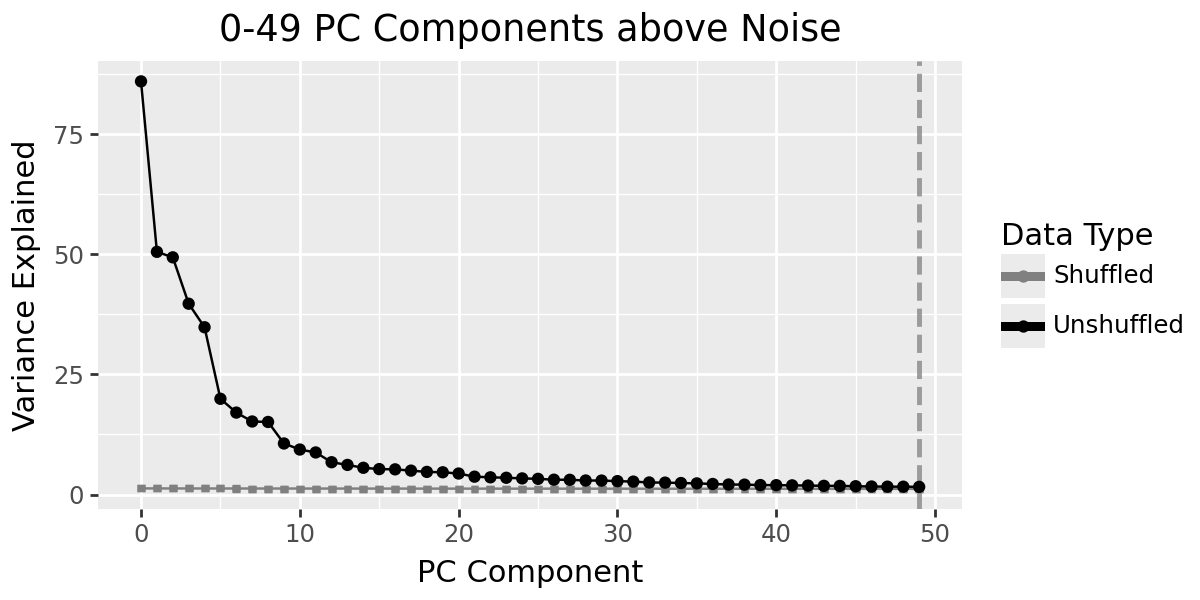

In [27]:
pt.compute_shuffled_pca(adata_bbknn)
pt.plot_shuffled_pca(adata_bbknn)

In [28]:
pt.set_obsm(adata=adata_bbknn, obsm_key="X_pca", n_dimensions=6)

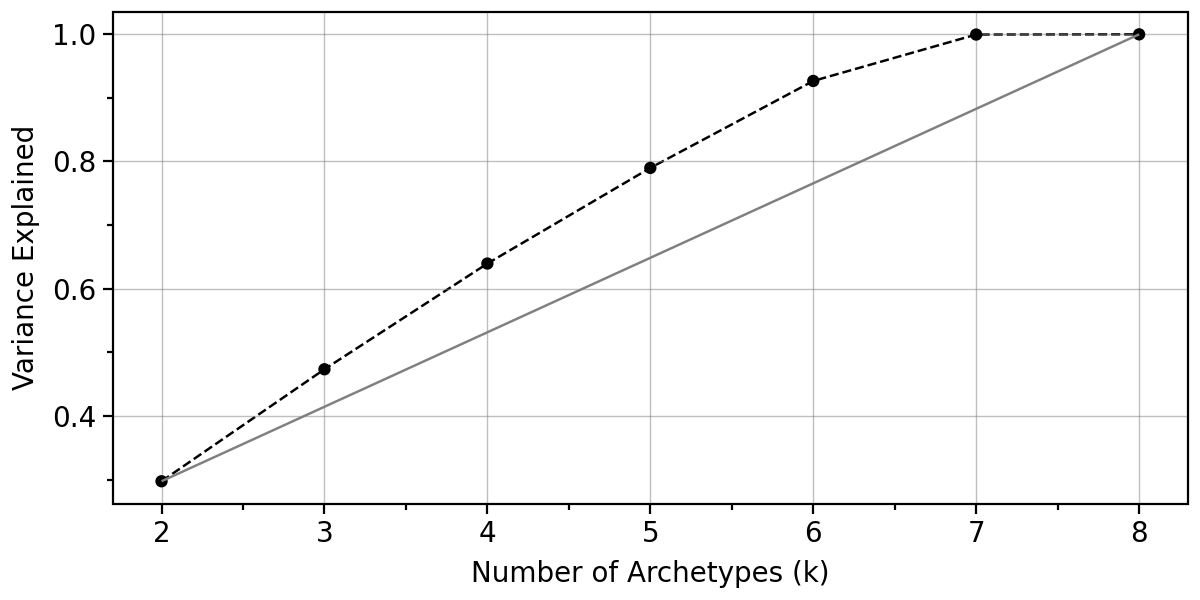

In [29]:
pt.compute_selection_metrics(adata=adata_bbknn, n_archetypes_list=range(2, 9), n_jobs=-1)
pt.plot_var_explained(adata_bbknn)



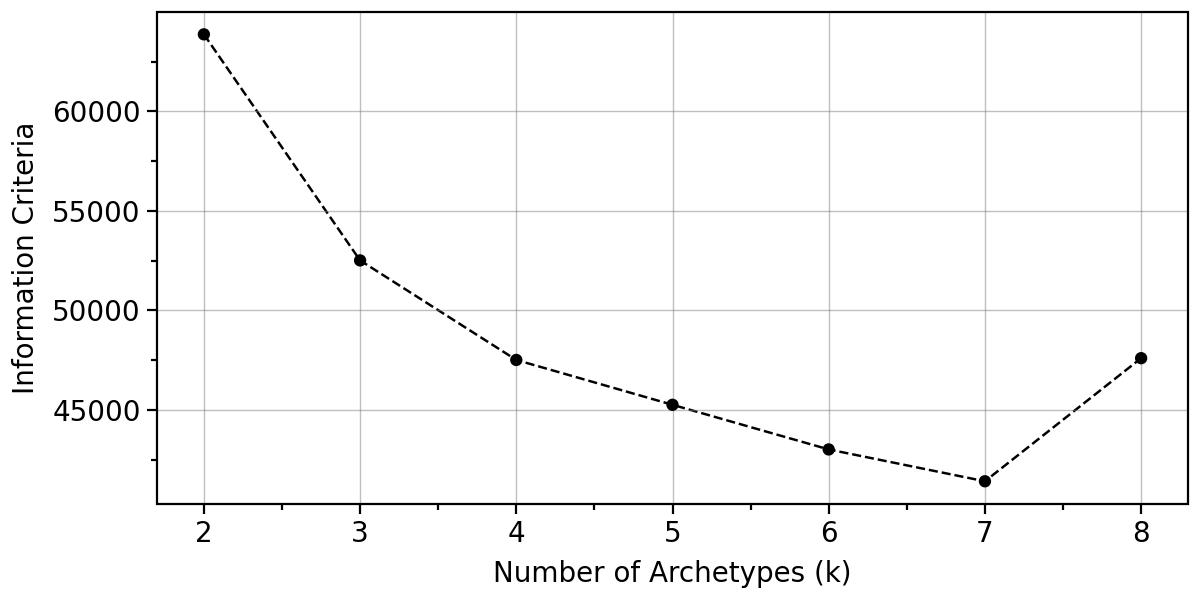

In [30]:
pt.plot_IC(adata_bbknn)


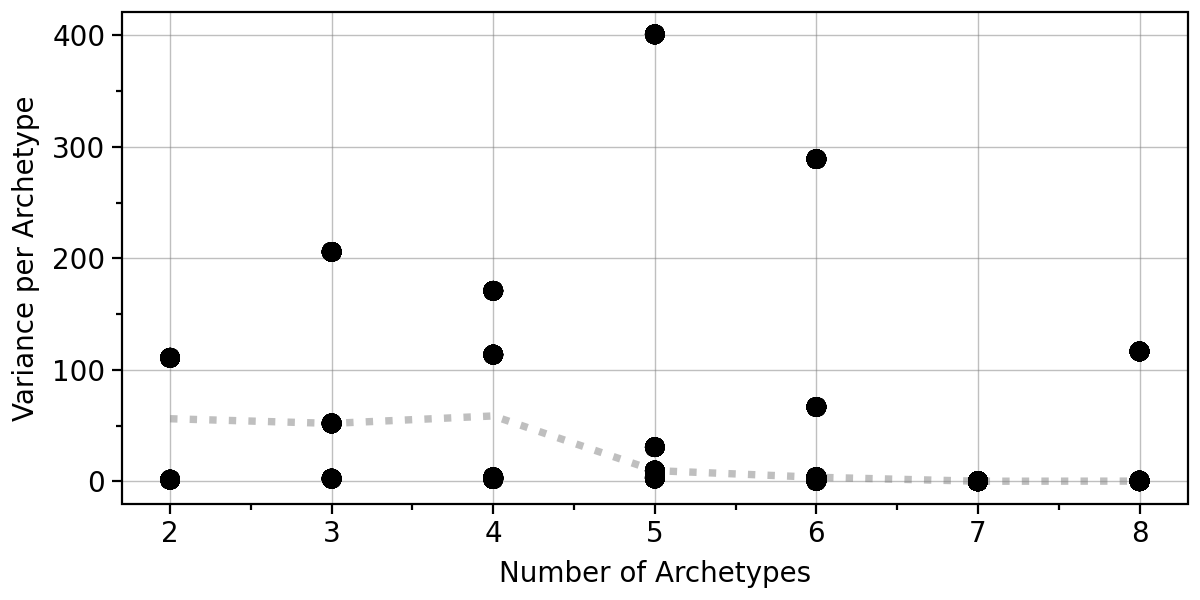

In [31]:
pt.compute_bootstrap_variance(adata=adata_bbknn, n_bootstrap=50, n_archetypes_list=range(2, 9), n_jobs=-1)
pt.plot_bootstrap_variance(adata_bbknn)

c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\pydantic\main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `dict[str, any]` - serialized value may not be as expected [field_name='optim_kwargs', input_value=(), input_type=tuple])


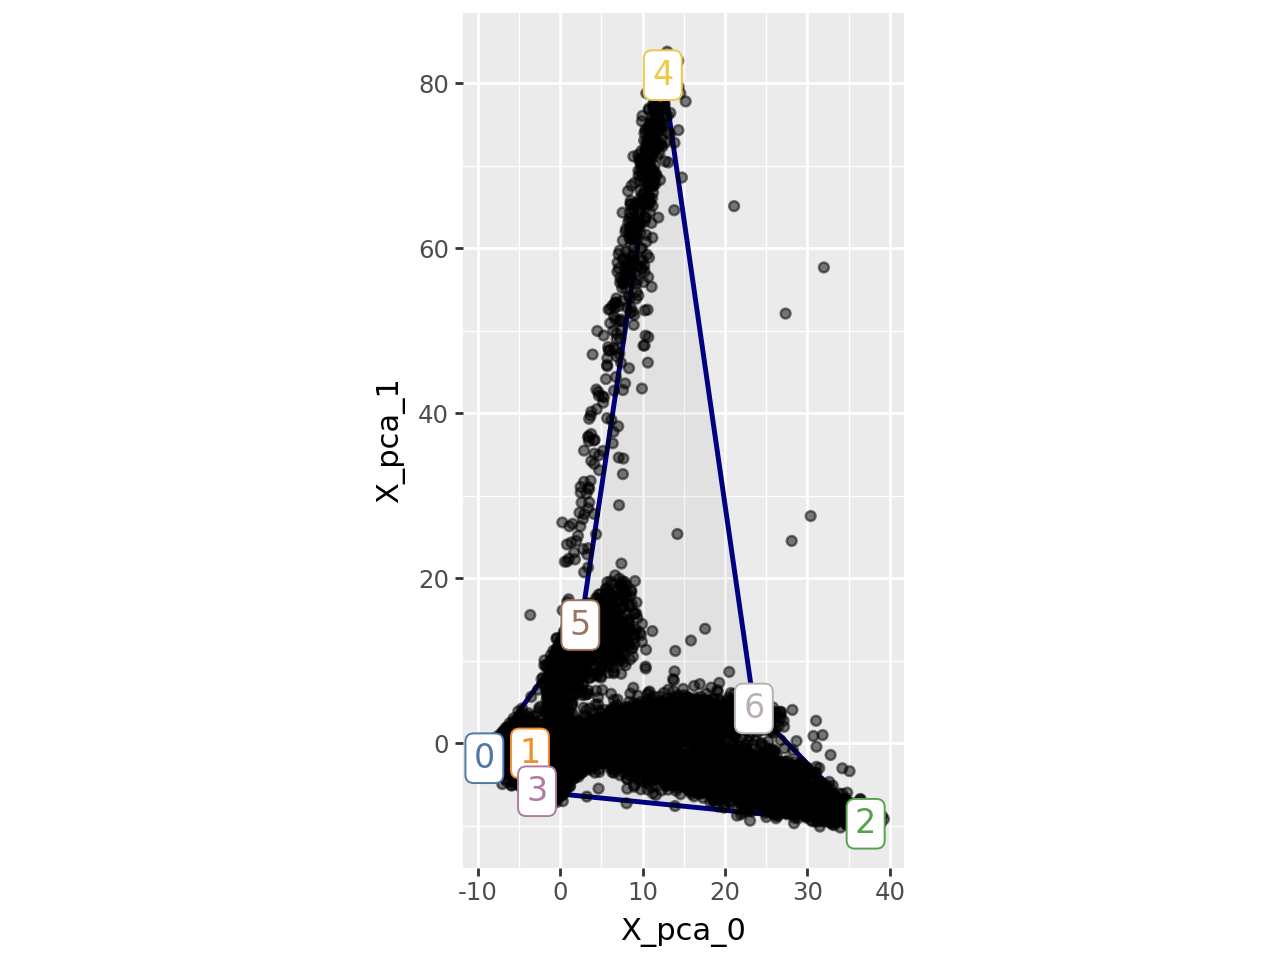

In [32]:
pt.compute_archetypes(adata_bbknn, n_archetypes=7, archetypes_only=False, n_jobs=-1)

pt.plot_archetypes_2D(adata=adata_bbknn, show_contours=True, result_filters={"n_archetypes": 7, "delta": 0.0})

In [33]:
significance = pt.t_ratio_significance(adata_bbknn, result_filters={"n_archetypes": 7, "delta": 0.0}, n_jobs=-1)
significance

Randomizing: 100%|██████████| 100/100 [09:55<00:00,  5.95s/it]


{'t_ratio_p_value': np.float64(0.0), 'rss_p_value': np.float64(0.0)}

In [34]:
arch_idx = 0

Applied length scale is 12.03.


c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\plotnine\scales\scale_size.py:46: PlotnineWarning: Using size for a discrete variable is not advised.


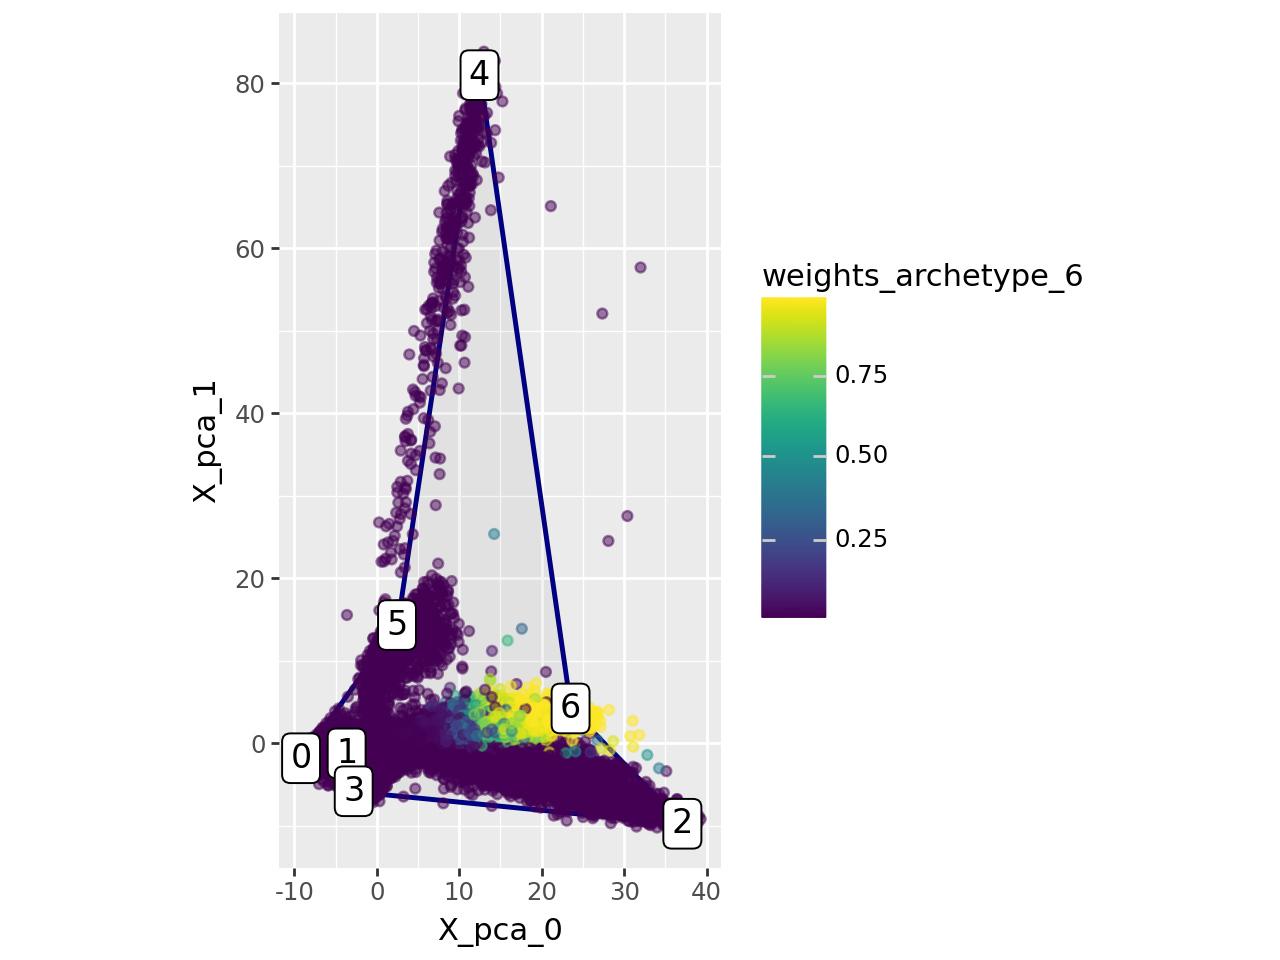

In [68]:
pt.compute_archetype_weights(adata=adata_bbknn, mode="automatic", result_filters={"n_archetypes": 7, "delta": 0.0})
archetype_expression = pt.compute_archetype_expression(adata=adata_bbknn, layer="z_scaled", result_filters={"n_archetypes": 7, "delta": 0.0})

adata_bbknn.obs[f"weights_archetype_{arch_idx}"] = pt.get_aa_cell_weights(adata_bbknn, n_archetypes=7, delta=0.0)[:, arch_idx]
pt.plot_archetypes_2D(adata=adata_bbknn, color=f"weights_archetype_{arch_idx}", result_filters={"n_archetypes": 7, "delta": 0.0})

c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\plotnine\scales\scale_size.py:46: PlotnineWarning: Using size for a discrete variable is not advised.


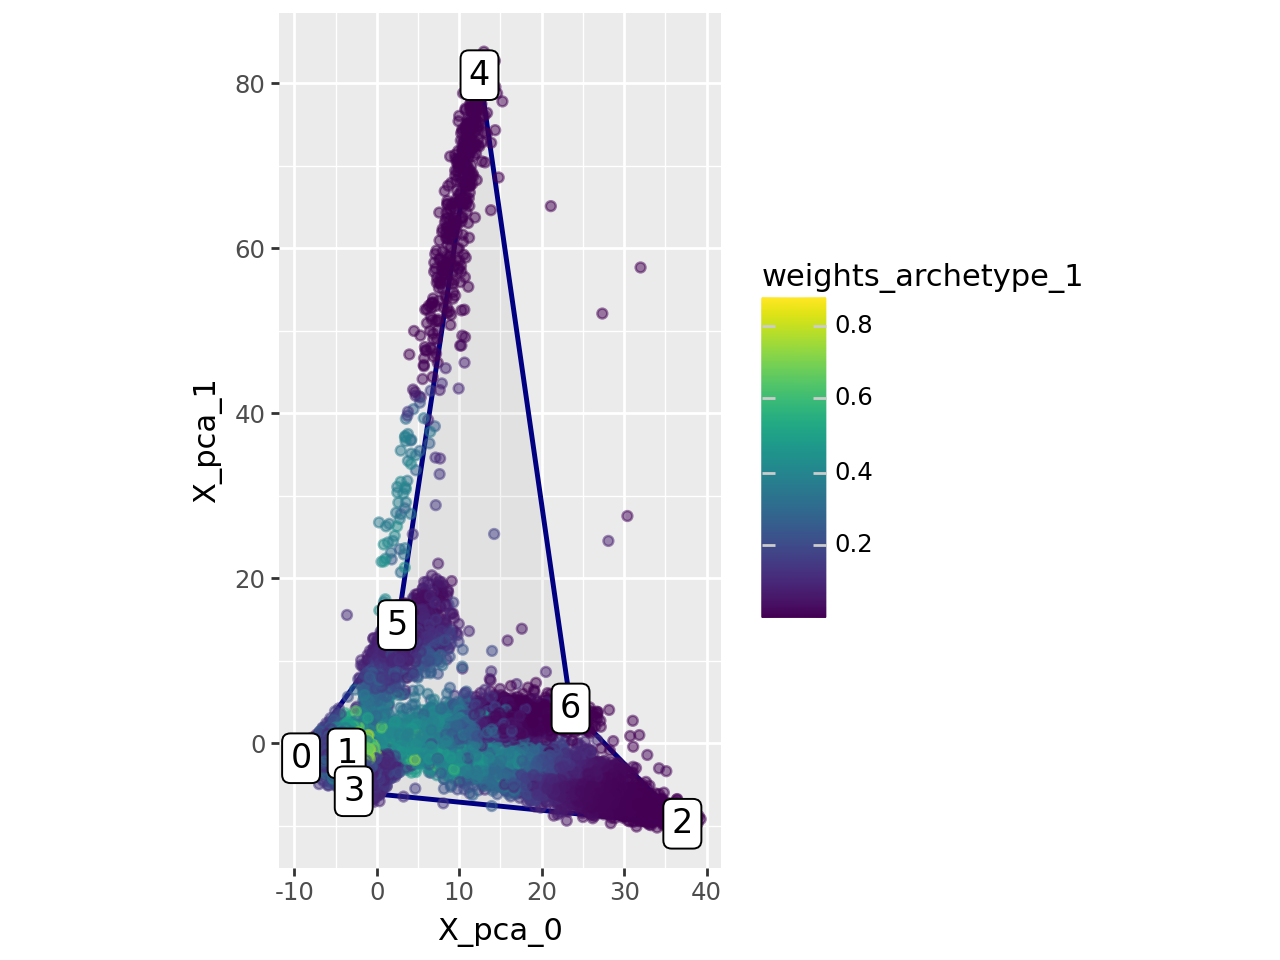

In [45]:

weights = pt.get_aa_cell_weights(adata_bbknn, n_archetypes=7, delta=0.0)

for arch_idx in range(weights.shape[1]):
    adata_bbknn.obs[f"weights_archetype_{arch_idx}"] = weights[:, arch_idx]


pt.plot_archetypes_2D(
    adata=adata_bbknn,
    color="weights_archetype_1",
    result_filters={"n_archetypes": 7, "delta": 0.0}
)

c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\plotnine\scales\scale_size.py:46: PlotnineWarning: Using size for a discrete variable is not advised.


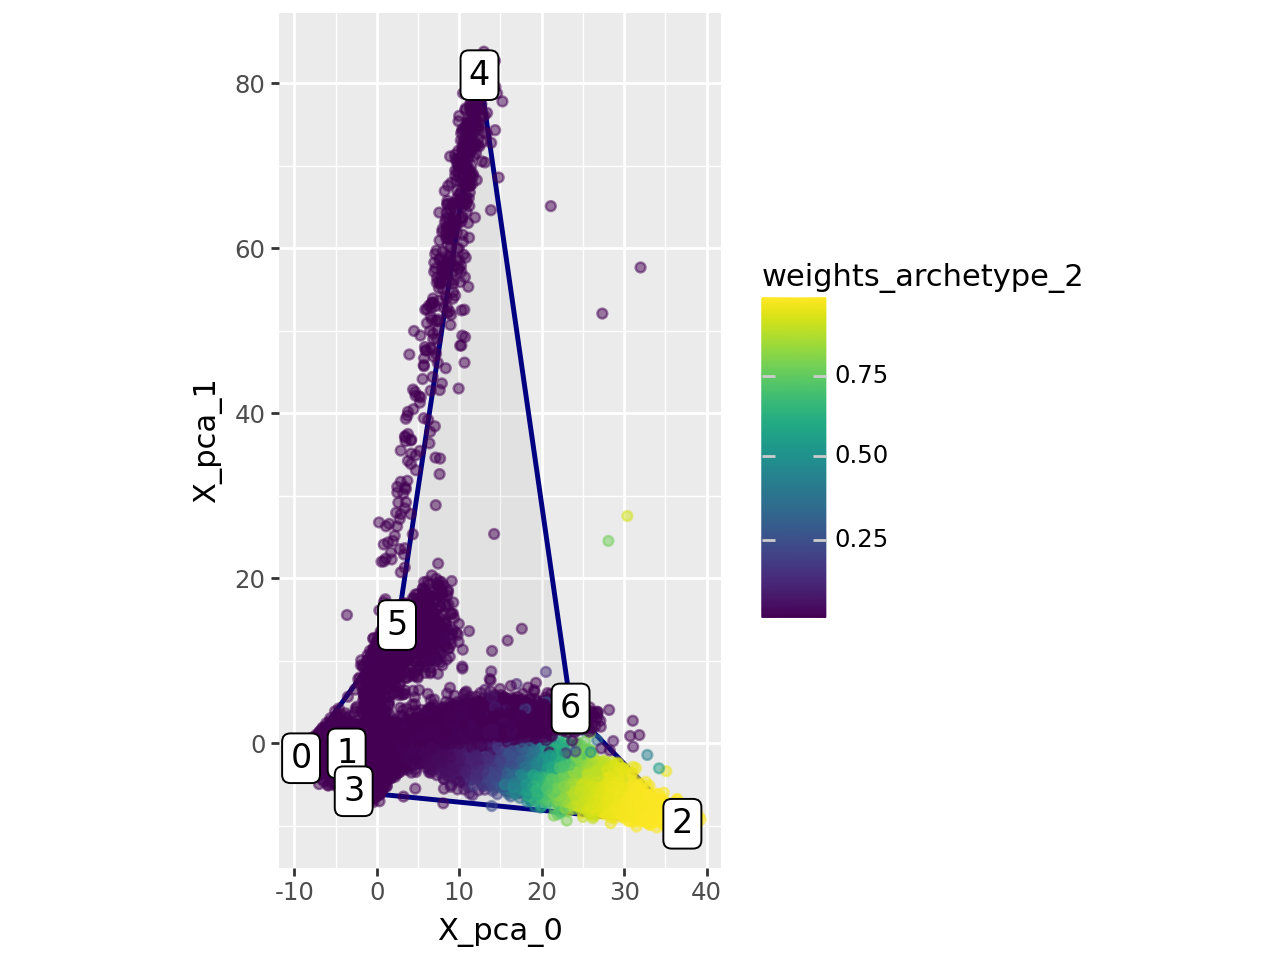

In [46]:
pt.plot_archetypes_2D(
    adata=adata_bbknn,
    color="weights_archetype_2",
    result_filters={"n_archetypes": 7, "delta": 0.0}
)

c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\plotnine\scales\scale_size.py:46: PlotnineWarning: Using size for a discrete variable is not advised.


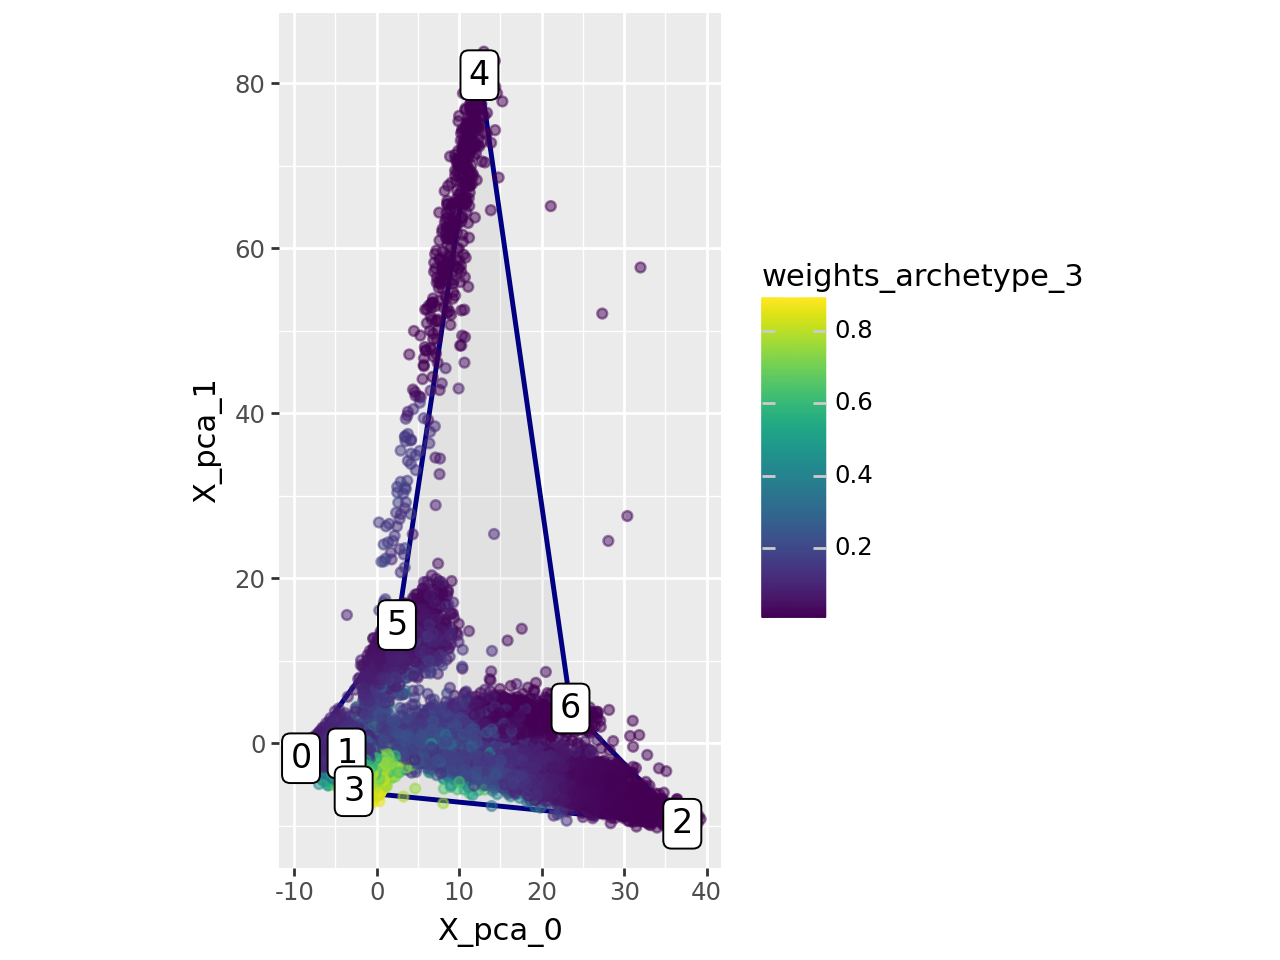

In [47]:
pt.plot_archetypes_2D(
    adata=adata_bbknn,
    color="weights_archetype_3",
    result_filters={"n_archetypes": 7, "delta": 0.0}
)

c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\plotnine\scales\scale_size.py:46: PlotnineWarning: Using size for a discrete variable is not advised.


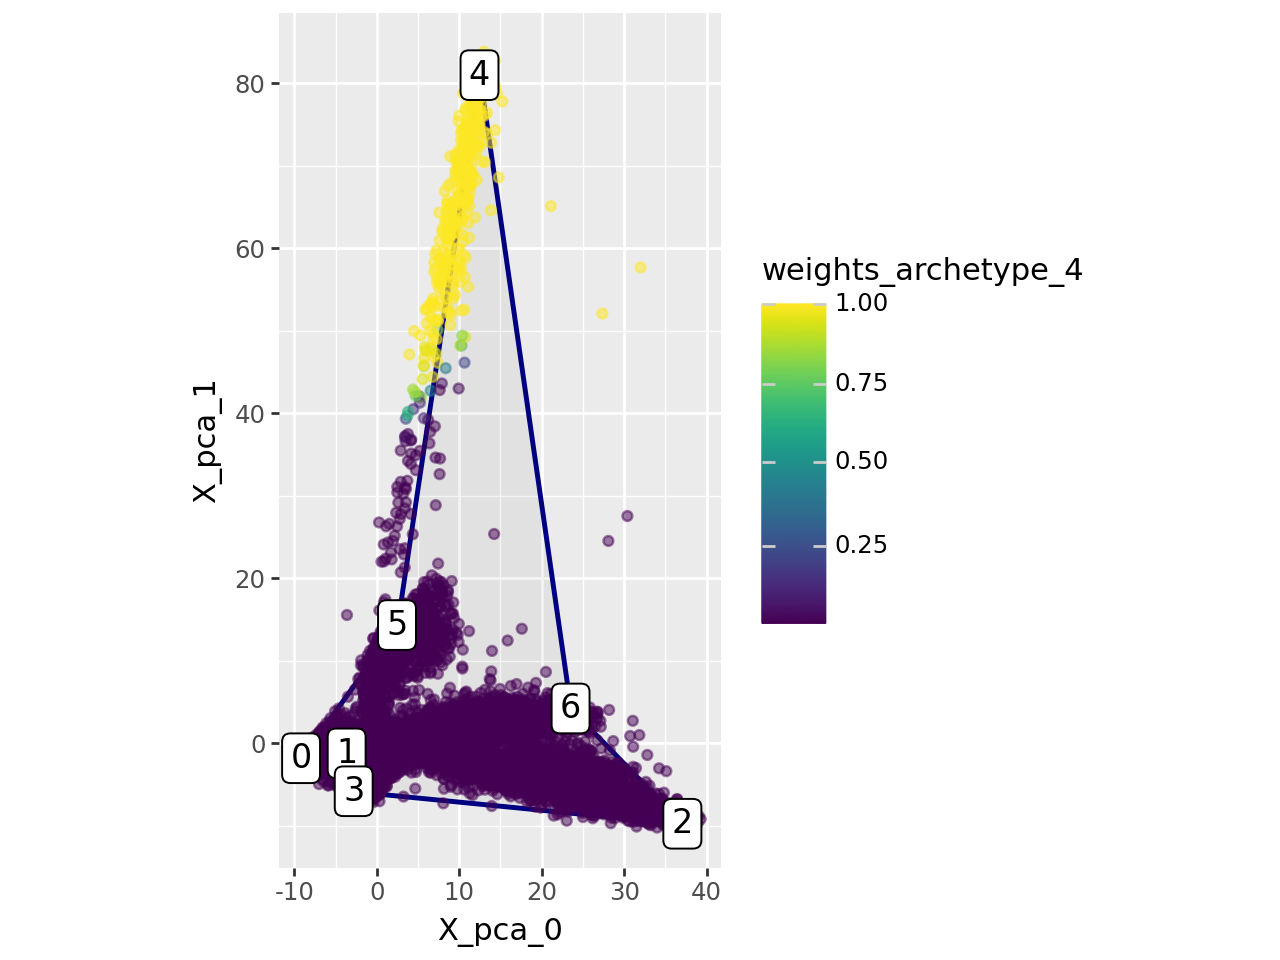

In [48]:
pt.plot_archetypes_2D(
    adata=adata_bbknn,
    color="weights_archetype_4",
    result_filters={"n_archetypes": 7, "delta": 0.0}
)

c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\plotnine\scales\scale_size.py:46: PlotnineWarning: Using size for a discrete variable is not advised.


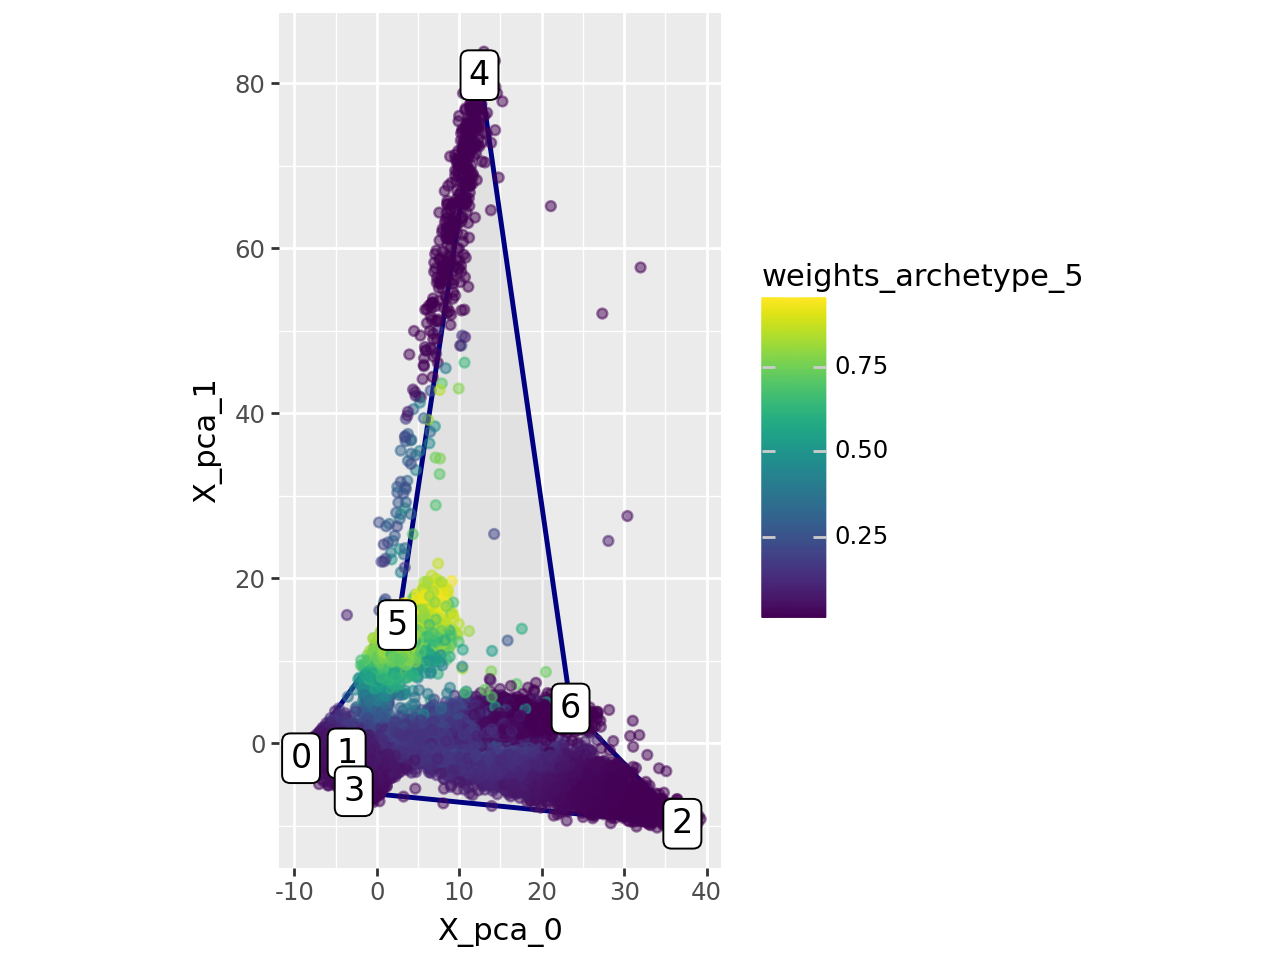

In [49]:
pt.plot_archetypes_2D(
    adata=adata_bbknn,
    color="weights_archetype_5",
    result_filters={"n_archetypes": 7, "delta": 0.0}
)

c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\plotnine\scales\scale_size.py:46: PlotnineWarning: Using size for a discrete variable is not advised.


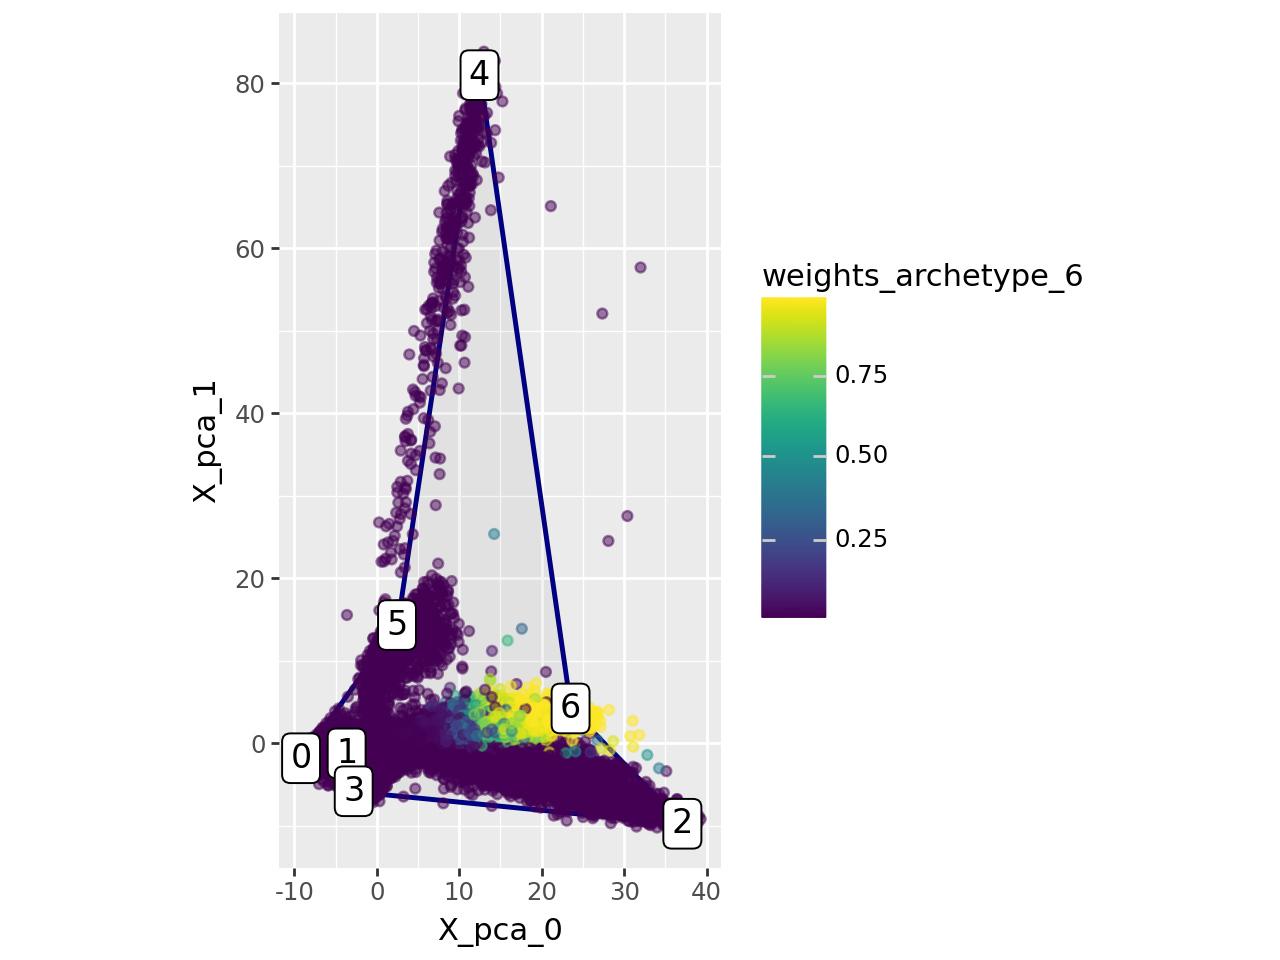

In [50]:

pt.plot_archetypes_2D(
    adata=adata_bbknn,
    color="weights_archetype_6",
    result_filters={"n_archetypes": 7, "delta": 0.0}
)



In [89]:
from plotnine import theme, element_text, guides, guide_legend

fig = (pt.plot_archetypes_2D(
    adata=adata_bbknn,
    color="cell_type",
    result_filters={"n_archetypes": 7, "delta": 0.0}
)
+ theme(
    figure_size=(20, 15),                # делаем картинку больше
    legend_position=(0.95, 0.95),        # правый верхний угол
    legend_justification=(1, 1),         # якорим легенду к углу
    legend_text=element_text(size=8),    # уменьшаем шрифт легенды
    legend_title=element_text(size=9)    # уменьшаем заголовок
)
+ guides(color=guide_legend(ncol=1))     # легенда в одну колонку
)

# Сохранение в файл
fig.save("archetypes_plot_large.png", dpi=300)



c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\plotnine\ggplot.py:623: PlotnineWarning: Saving 20 x 15 in image.
c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\plotnine\ggplot.py:624: PlotnineWarning: Filename: archetypes_plot_large.png
c:\Users\1\miniconda3\envs\jupiter_isaev\Lib\site-packages\plotnine\scales\scale_size.py:46: PlotnineWarning: Using size for a discrete variable is not advised.


In [70]:
# допустим, в var есть 'gene_symbols'
gene_map = (
    adata_bbknn.var
    .reset_index()
    .set_index("index")["gene_symbols"]
)

# удаляем пустые
gene_map = gene_map[gene_map.notna()]


# заменяем ENSG на gene symbols
archetype_expression = archetype_expression.rename(
    columns=gene_map
)

archetype_expression

KLHL17         HES4        ISG15     TNFRSF18      TNFRSF4      SCNN1D  \
0 -492.154660 -1774.278863   450.264857  2799.466959   626.251254 -529.295658   
1 -554.416696  -970.801337  -950.556977  1092.433838  1563.105171 -517.561713   
2  276.953941   923.448260  -799.916439  -933.126548  -677.039481  180.075613   
3 -196.779259  2161.728828  2653.860910 -1463.581052  -917.187996 -326.423746   
4   31.641964   240.783255   -65.761162   -87.712520   -74.190195   14.232247   
5  -44.891291  -672.873811 -1630.187740 -1020.188135  -782.860025 -196.227507   
6  -13.095045    91.993671   342.296548  -387.292544   259.849613   14.653743   

   RP5-832C2.5  RP11-345P4.7       PLCH2  RP3-395M20.12  ...         TFF3  \
0  1041.014841   -207.426877  286.591024    1661.124968  ... -1039.664379   
1   -31.569659   -225.918002 -247.613877    -414.712655  ...  -627.889160   
2  -290.441045    -58.117537 -245.252158    -812.209432  ...  -292.327615   
3  -327.034537   -177.280414 -579.014822     616.345892  ...  -792.391590   
4   -19.377455      3.801500   17.507255      72.353293  ...  1503.706466   
5  -344.641991   -116.246728 -257.327004    -827.893507  ...   495.240227   
6   -90.411669    -28.264342 -110.646347    -295.008567  ...   564.801169   

         RSPH1         CSTB     TRAPPC10        COL6A1        COL6A2  \
0 -1234.983588 -5495.294526  1267.211787  -3787.615177  -2887.479804   
1 -1174.659737 -3344.946265  -235.293082  -3066.342409  -3128.304058   
2  -255.760946   136.162798  -344.309762  11175.527419  10941.633170   
3  -968.140995  5437.270915  -212.325907  -2623.389735  -2912.064891   
4  3413.601480   240.763398     1.119675    -62.344863   -104.047259   
5  -163.626622  3201.456742  -347.249511  -1519.590014  -1673.762103   
6   -97.210793  -175.413065  -133.589771   -116.245220   -235.975051   

      C21orf58        DIP2A        S100B       MT-CO1  
0  -761.138106  2797.432662  1687.626354  -314.874833  
1  -970.540828  -597.419256  -670.505745   687.402050  
2     0.031096  -398.657290  -518.462742 -2787.378491  
3  -729.418498 -1201.385730   557.853505  4076.448992  
4  2364.684989    -2.303591   -63.150896  -119.894888  
5  -222.622075  -546.377577  -736.766268  -176.987793  
6   -79.243325   -51.289219  -256.754134 -1364.715046  

[7 rows x 3000 columns]

In [71]:
archetype_expression.T.sort_values(arch_idx, ascending=False).head(10)

0            1           2            3           4  \
VWF     -2103.668444 -1666.719649 -564.175386 -1532.263778  -36.302881   
RAMP2   -2417.741825 -1705.896829  458.158930 -1887.394927  -54.261562   
CLEC14A -2022.012681 -1494.848421 -569.363997 -1593.950211  -54.521225   
CLDN5   -2137.187091 -1345.835785 -591.737696 -1500.893728  -50.595583   
PCAT19  -2110.312448 -1436.418388 -363.344112 -1666.864033  136.753659   
RAMP3   -1901.635353 -1428.665007 -504.132815 -1561.169240  -46.741842   
CALCRL  -2066.613522 -1532.493296 -275.547787 -1448.354935  -55.917276   
ECSCR-1 -2029.799148 -1292.259454 -727.831202 -1028.997384  -71.097112   
EGFL7   -2540.142193 -1619.697749 -507.636936 -1623.562001  -65.736600   
TM4SF1  -2928.614269 -1961.559789   62.964991 -2363.010687    3.750301   

                   5            6  
VWF      -723.451175  6626.580947  
RAMP2    -835.605076  6442.741289  
CLEC14A  -688.510436  6423.189204  
CLDN5    -653.262624  6279.512503  
PCAT19   -703.814247  6143.999568  
RAMP3    -695.098587  6137.442143  
CALCRL   -719.254991  6098.030900  
ECSCR-1  -615.194263  5765.178562  
EGFL7     638.706967  5718.068512  
TM4SF1   1601.488407  5584.981047

In [54]:
import decoupler as dc

database = "reactome_pathways"

min_genes_per_pathway = 5
max_genes_per_pathway = 80

msigdb_raw = dc.op.resource("MSigDB")


In [55]:
msigdb = msigdb_raw.loc[
    msigdb_raw["collection"] == database
].copy()


In [56]:
selection_vec = (
    ~msigdb["geneset"].str.contains("RESPONSE_TO", regex=False) &
    ~msigdb["geneset"].str.contains("GENE_EXPRESSION", regex=False) &
    ~msigdb["geneset"].str.contains("SARS_COV", regex=False) &
    ~msigdb["geneset"].str.contains("STIMULATED_TRANSCRIPTION", regex=False)
)

msigdb = msigdb.loc[selection_vec].copy()


In [57]:
msigdb = msigdb.drop_duplicates(
    subset=["geneset", "genesymbol"]
)

geneset_sizes = msigdb.value_counts("geneset")

genesets_to_keep = geneset_sizes[
    (geneset_sizes >= min_genes_per_pathway) &
    (geneset_sizes <= max_genes_per_pathway)
].index.tolist()

msigdb = msigdb.loc[
    msigdb["geneset"].isin(genesets_to_keep)
].copy()


In [ ]:
msigdb = msigdb.rename(
    columns={
        "geneset": "source",
        "genesymbol": "target"
    }
)

target         collection  \
                                      
276         A1CF  reactome_pathways   
282         A1CF  reactome_pathways   
318          A2M  reactome_pathways   
427          A2M  reactome_pathways   
487          A2M  reactome_pathways   
...          ...                ...   
5889257      ZP3  reactome_pathways   
5889363      ZP4  reactome_pathways   
5889412      ZP4  reactome_pathways   
5890666  ZSCAN10  reactome_pathways   
5891875   ZSCAN4  reactome_pathways   

                                                    source  
                                                            
276                REACTOME_MRNA_EDITING_C_TO_U_CONVERSION  
282                                  REACTOME_MRNA_EDITING  
318      REACTOME_INTRINSIC_PATHWAY_OF_FIBRIN_CLOT_FORM...  
427                                  REACTOME_HDL_ASSEMBLY  
487                   REACTOME_PLASMA_LIPOPROTEIN_ASSEMBLY  
...                                                    ...  
5889257  REACTOME_INTERACTION_WITH_CUMULUS_CELLS_AND_TH...  
5889363  REACTOME_INTERACTION_WITH_CUMULUS_CELLS_AND_TH...  
5889412                             REACTOME_FERTILIZATION  
5890666  REACTOME_TRANSCRIPTIONAL_REGULATION_OF_PLURIPO...  
5891875             REACTOME_ZYGOTIC_GENOME_ACTIVATION_ZGA  

[37107 rows x 3 columns]

In [76]:
organism = adata_bbknn.uns.get("organism", "human").lower()

msigdb_net = msigdb.copy()

common_genes = archetype_expression.columns.intersection(
    msigdb_net["target"]
)

archetype_expression = archetype_expression.loc[:, common_genes]
msigdb_net = msigdb_net.loc[
    msigdb_net["target"].isin(common_genes)
]


In [77]:
acts_ulm_est, acts_ulm_pvals = dc.mt.ulm(
    data=archetype_expression,
    net=msigdb_net,
    verbose=False
)
acts_ulm_est.iloc[:4, :4]


REACTOME_ACTIVATION_OF_BH3_ONLY_PROTEINS  \
0                                  1.249594   
1                                  0.758548   
2                                 -1.043063   
3                                 -0.643582   

   REACTOME_ACTIVATION_OF_MATRIX_METALLOPROTEINASES  \
0                                         -1.160831   
1                                          1.015012   
2                                          0.637430   
3                                          0.604486   

   REACTOME_ADP_SIGNALLING_THROUGH_P2Y_PURINOCEPTOR_1  \
0                                           0.153652    
1                                           0.497846    
2                                          -0.267924    
3                                          -0.292998    

   REACTOME_ADVANCED_GLYCOSYLATION_ENDPRODUCT_RECEPTOR_SIGNALING  
0                                          -0.621735              
1                                          -1.041321              
2                                          -0.370226              
3                                           0.681785

In [78]:
top_processes = pt.extract_enriched_processes(
    est=acts_ulm_est,
    pval=acts_ulm_pvals,
    order="desc",
    n=10,
    p_threshold=0.05
)



In [82]:
import plotnine as pn
def plot_archetype_processes(
    df: pd.DataFrame,
    arch_idx: int,
    figsize=(10, 3)
):
    """
    df       : DataFrame из top_processes[arch_idx]
    arch_idx : индекс архетипа
    """

    value_col = str(arch_idx)

    # сортировка для корректного порядка столбцов
    df = df.sort_values(value_col, ascending=True).copy()

    # фиксируем порядок категорий
    df["Process"] = pd.Categorical(
        df["Process"],
        categories=df["Process"].tolist(),
        ordered=True
    )

    p = (
        pn.ggplot(df)
        + pn.geom_col(pn.aes(x="Process", y=value_col), fill="#4C72B0")
        + pn.coord_flip()
        + pn.labs(
            title=f"Archetype {arch_idx}: enriched processes",
            x="Process",
            y="ULM activity"
        )
        + pn.theme(
            figure_size=figsize,
            axis_text_y=pn.element_text(size=8),
            axis_title=pn.element_text(size=10),
            plot_title=pn.element_text(size=11, weight="bold")
        )
    )

    return p


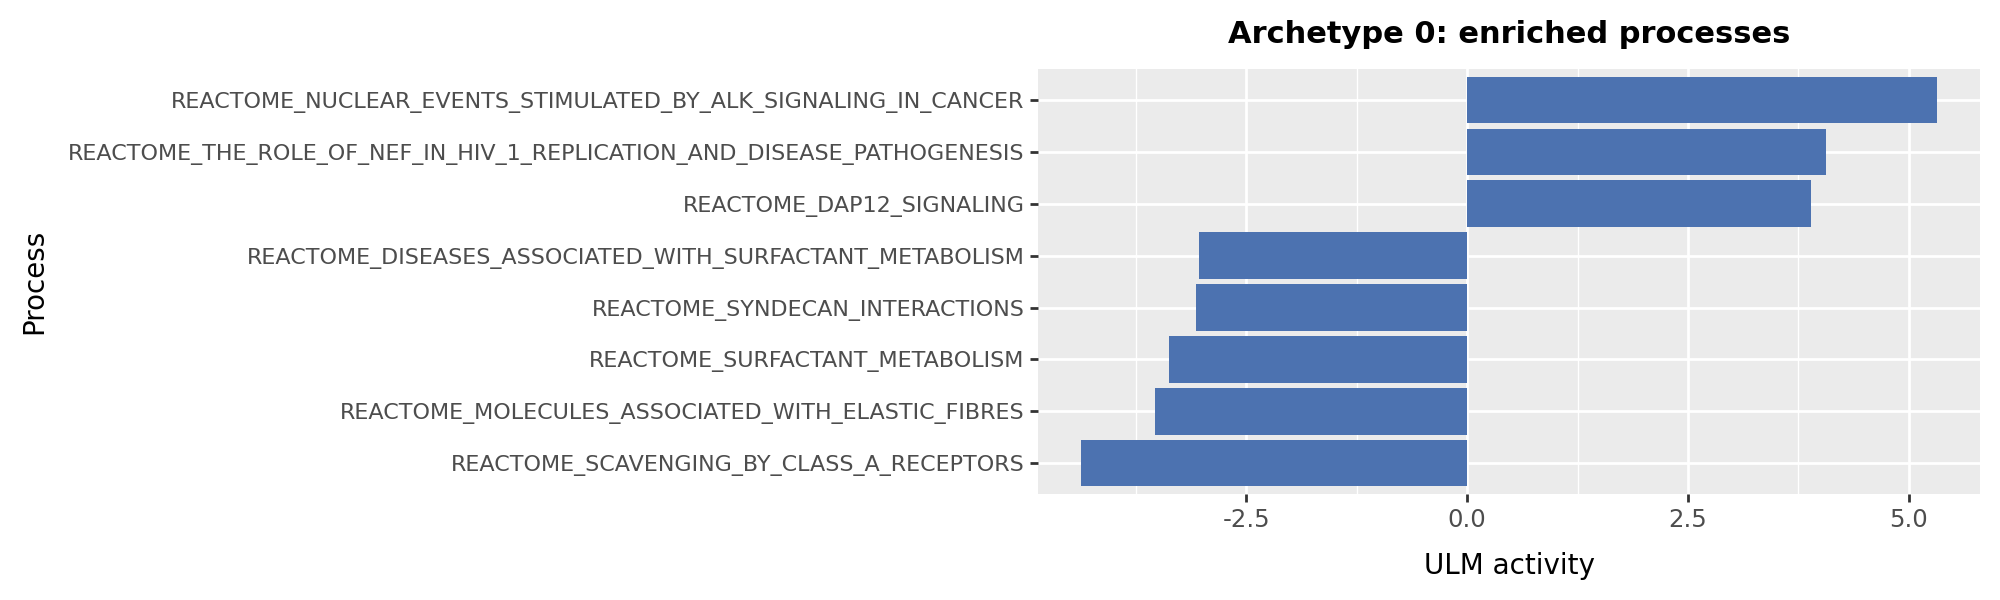

In [83]:
plots = {}
n_archetypes = 7

for arch_idx in range(n_archetypes):
    if arch_idx not in top_processes:
        print(f"Archetype {arch_idx}: no significant processes")
        continue

    plots[arch_idx] = plot_archetype_processes(
        top_processes[arch_idx],
        arch_idx
    )
plots[0]


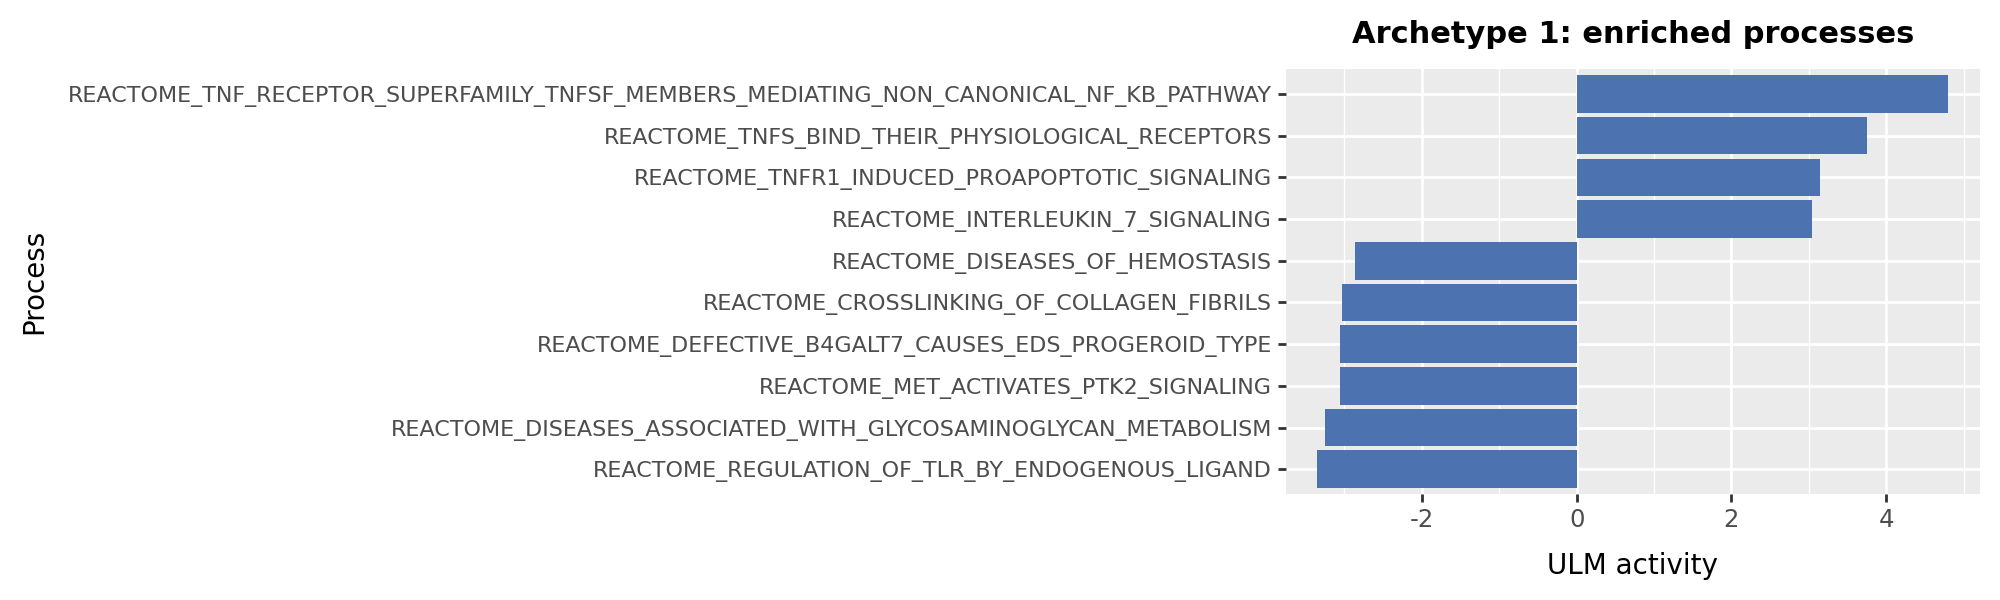

In [91]:
plots[1]

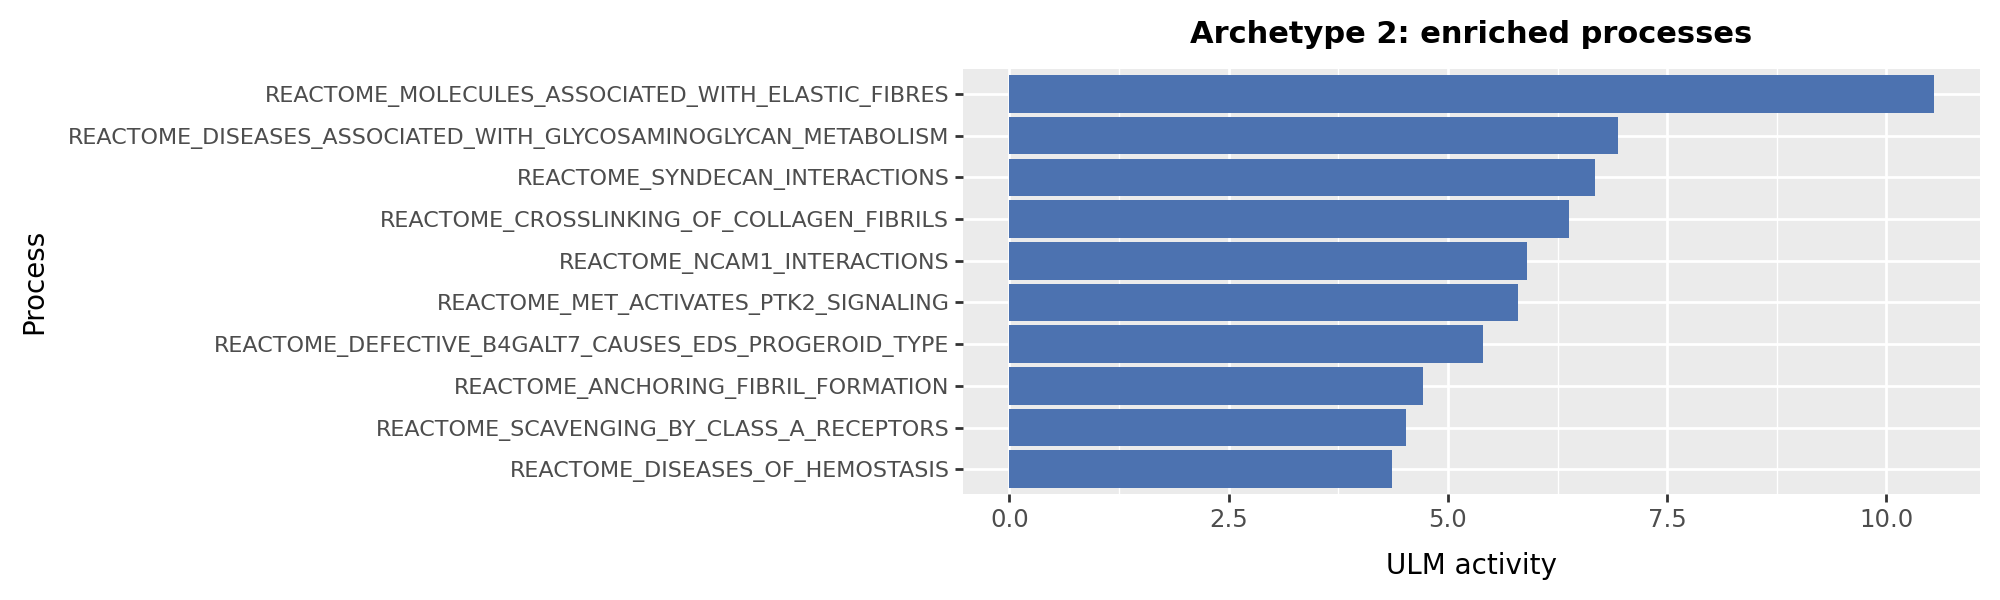

In [92]:
plots[2]

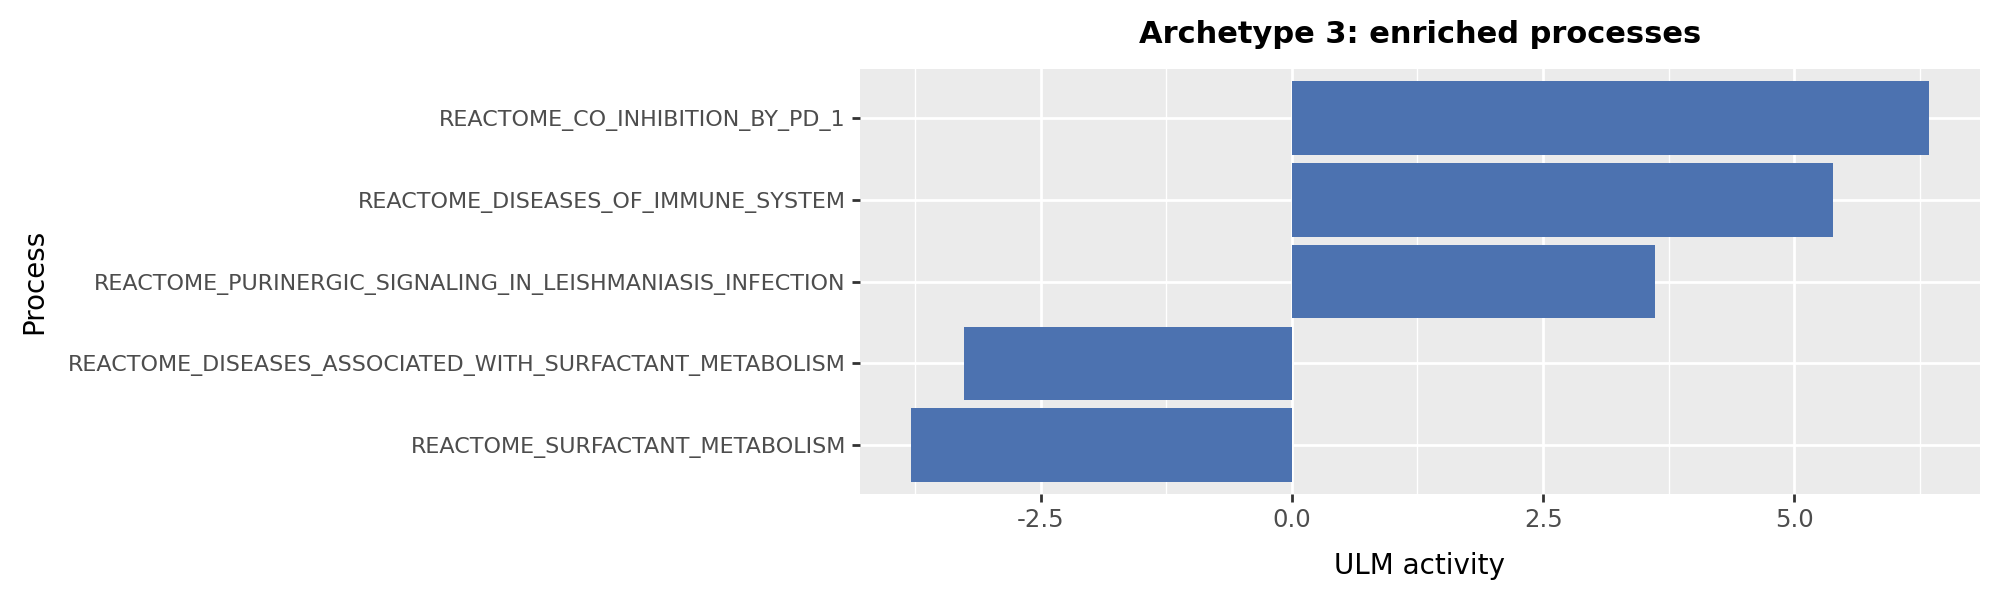

In [93]:
plots[3]

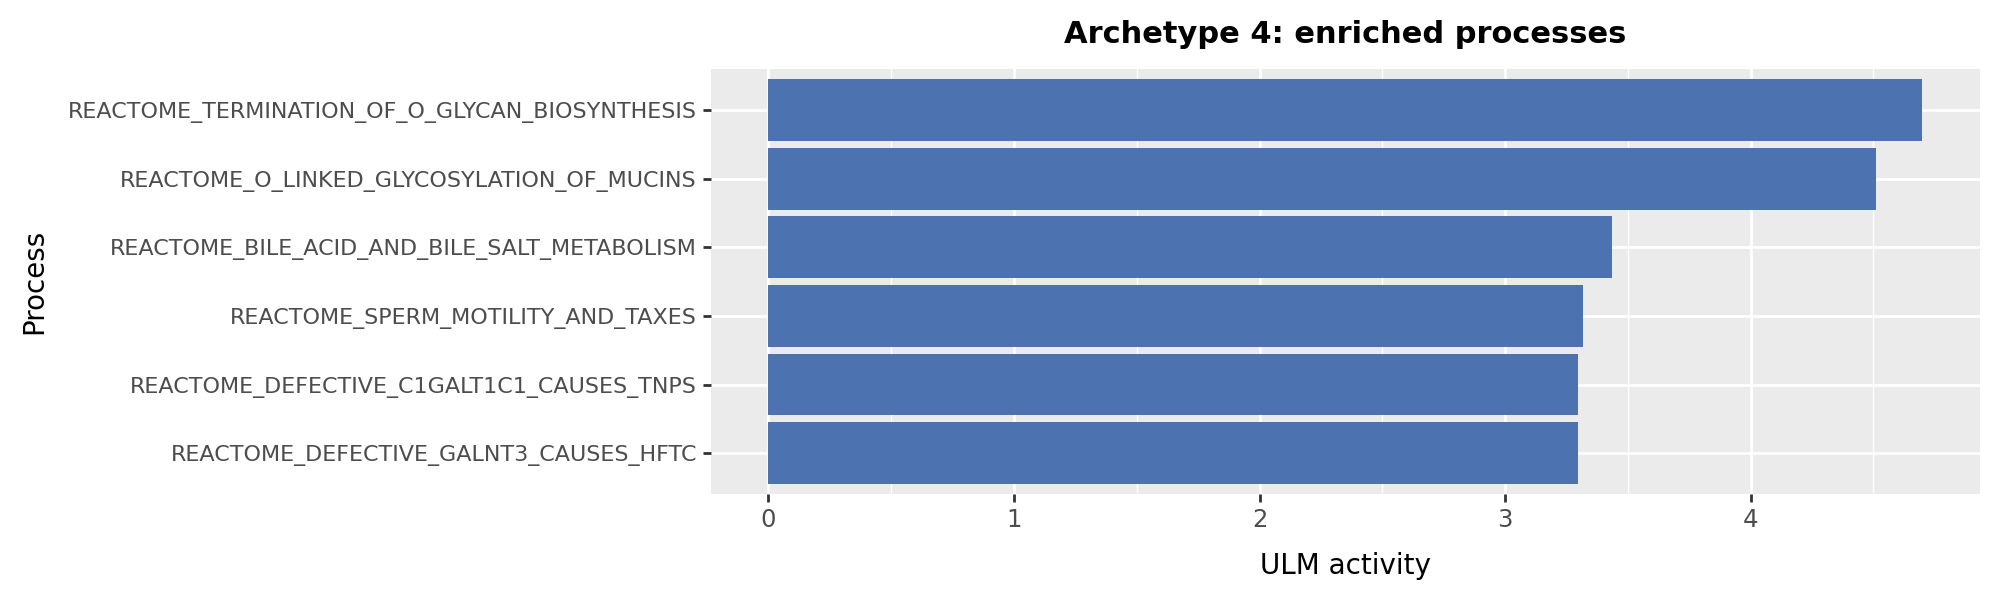

In [94]:
plots[4]

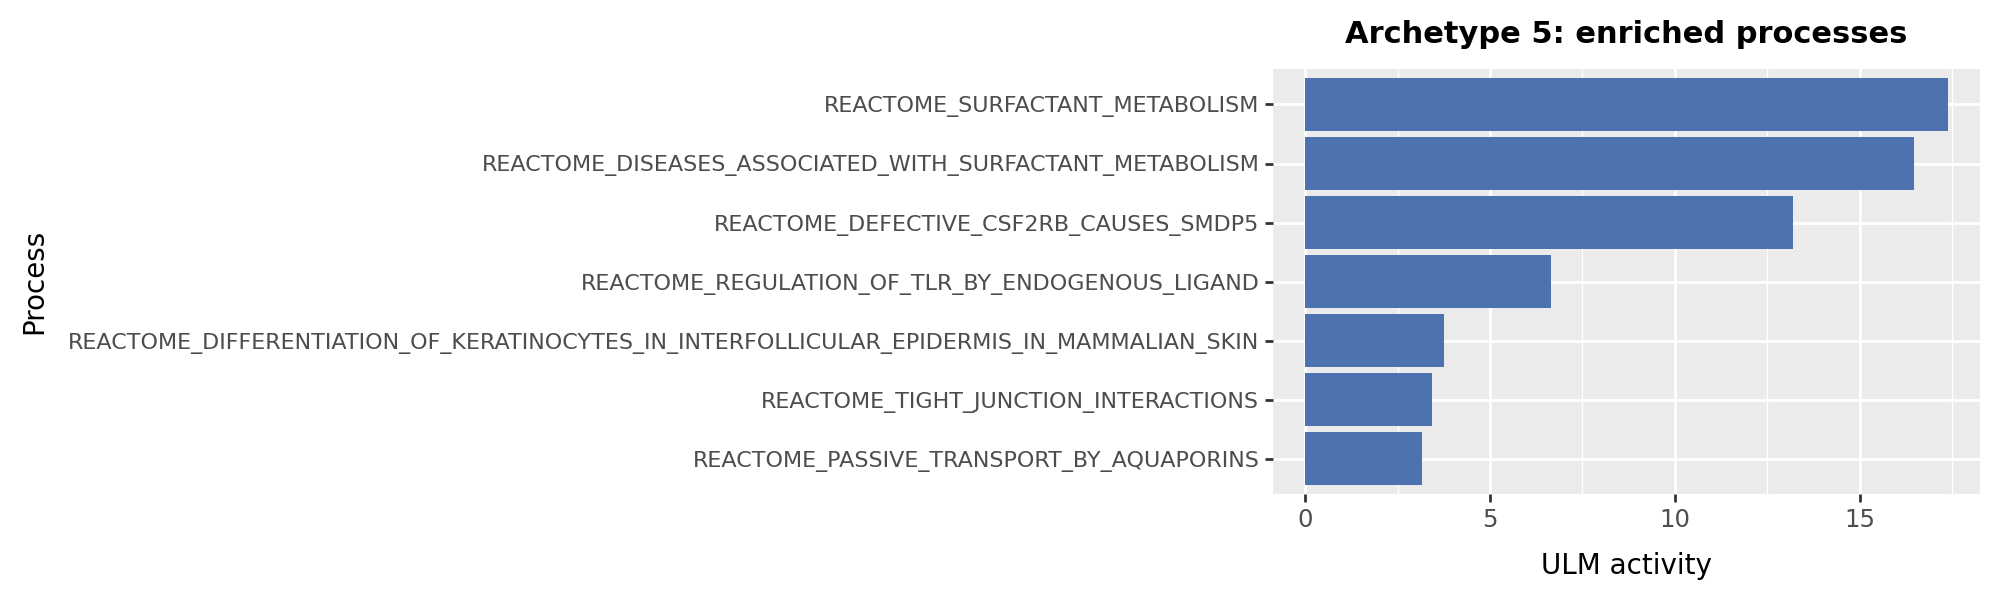

In [95]:
plots[5]

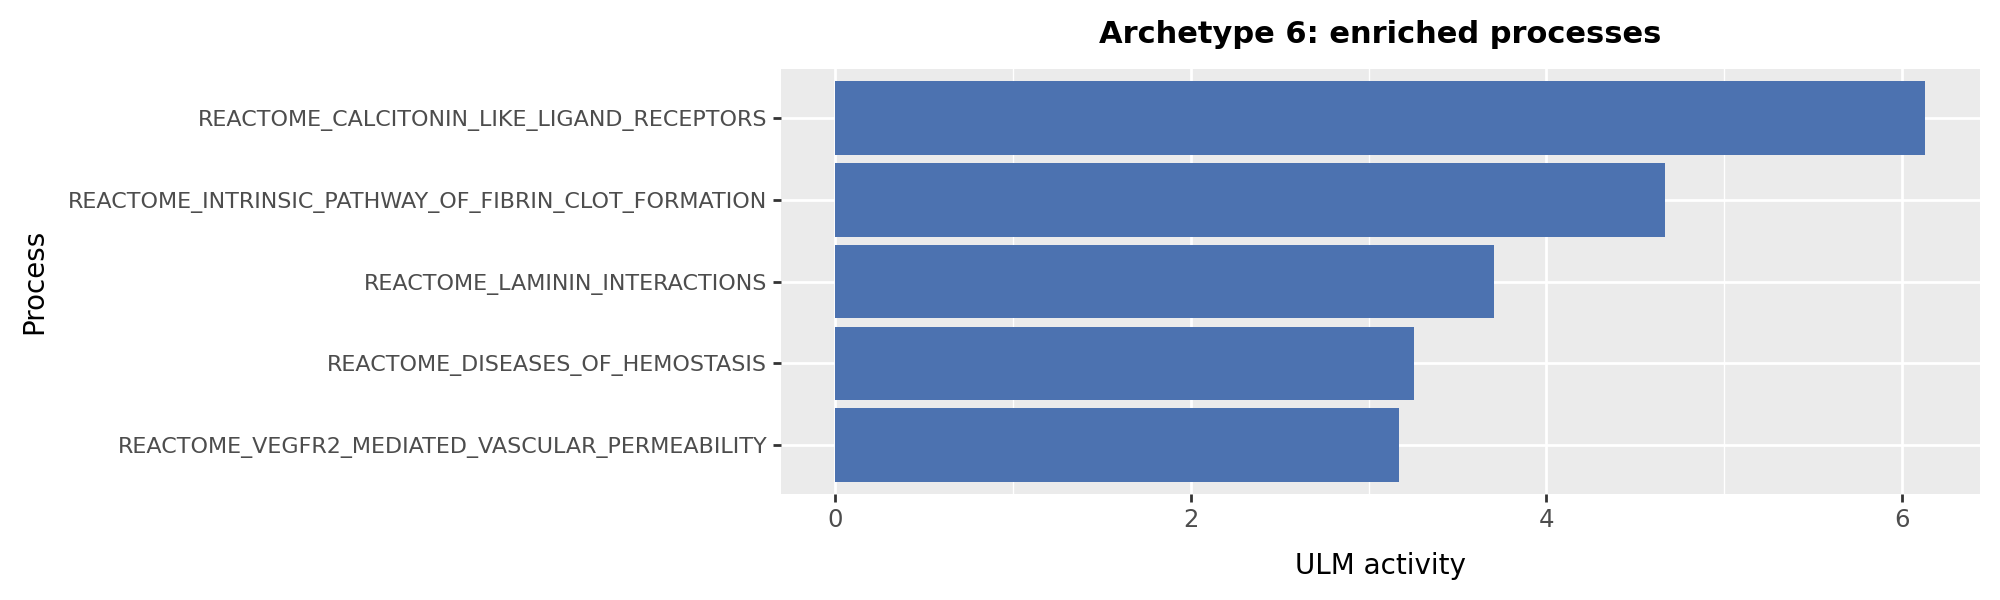

In [96]:
plots[6]

In [97]:
def get_top_genes(
    archetype_expression,
    arch_idx: int,
    n: int = 10,
    direction: str = "positive"  # "positive", "negative", "absolute"
):
    """
    Возвращает top-n генов для архетипа
    """

    s = archetype_expression.loc[arch_idx]

    if direction == "positive":
        s = s.sort_values(ascending=False)
    elif direction == "negative":
        s = s.sort_values(ascending=True)
    elif direction == "absolute":
        s = s.reindex(s.abs().sort_values(ascending=False).index)
    else:
        raise ValueError("direction must be positive / negative / absolute")

    df = (
        s.head(n)
        .reset_index()
        .rename(columns={"index": "Gene", arch_idx: "Contribution"})
    )

    return df


In [98]:
def plot_top_genes(
    df: pd.DataFrame,
    arch_idx: int,
    direction: str,
    figsize=(6, 3)
):
    df = df.sort_values("Contribution", ascending=True)

    df["Gene"] = pd.Categorical(
        df["Gene"],
        categories=df["Gene"].tolist(),
        ordered=True
    )

    p = (
        pn.ggplot(df)
        + pn.geom_col(
            pn.aes(x="Gene", y="Contribution"),
            fill="#4C72B0"
        )
        + pn.coord_flip()
        + pn.labs(
            title=f"Archetype {arch_idx}: top genes ({direction})",
            x="Gene",
            y="Archetype loading"
        )
        + pn.theme(
            figure_size=figsize,
            axis_text_y=pn.element_text(size=8),
            plot_title=pn.element_text(weight="bold")
        )
    )

    return p


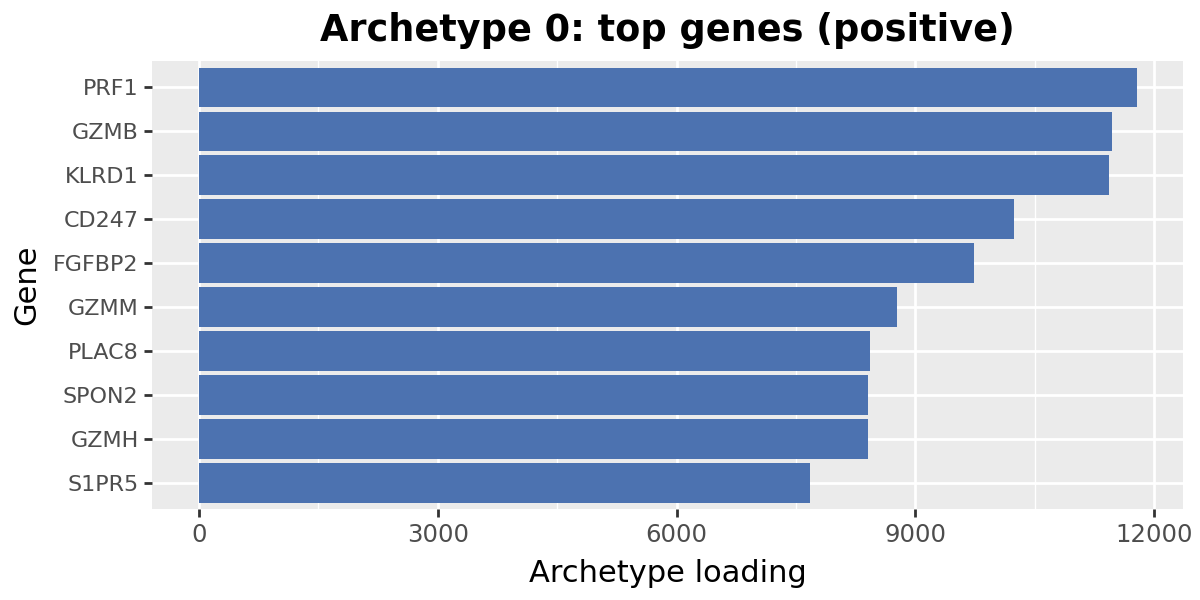

In [99]:
gene_plots = {}

for arch_idx in range(7):
    df = get_top_genes(
        archetype_expression,
        arch_idx=arch_idx,
        n=10,
        direction="positive"
    )

    gene_plots[arch_idx] = plot_top_genes(
        df,
        arch_idx,
        direction="positive"
    )
gene_plots[0]

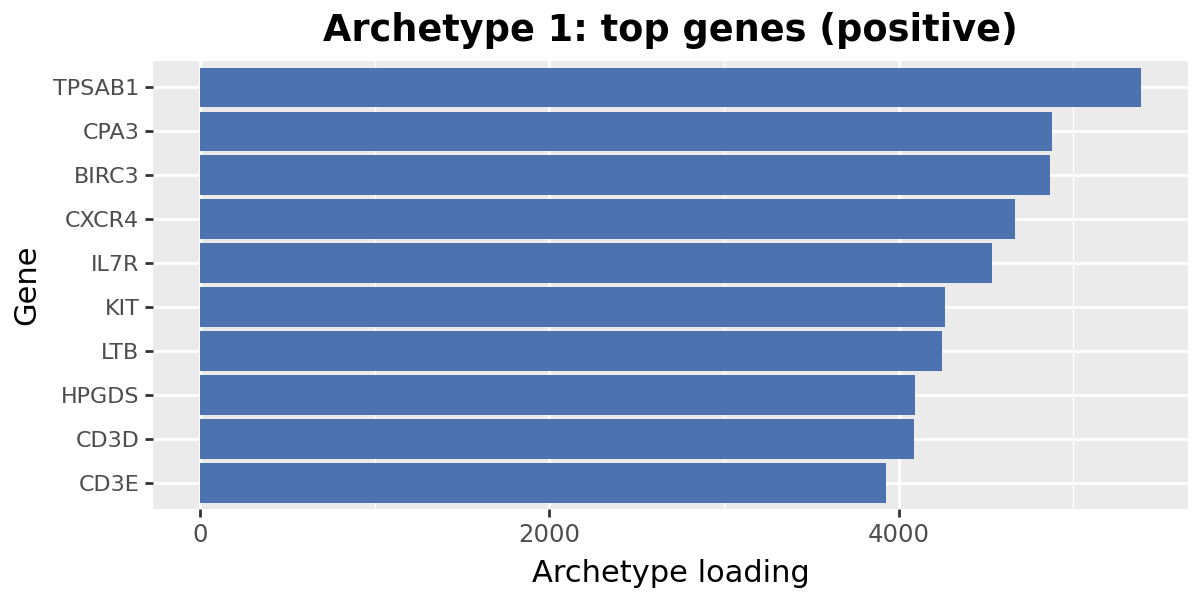

In [100]:
gene_plots[1]

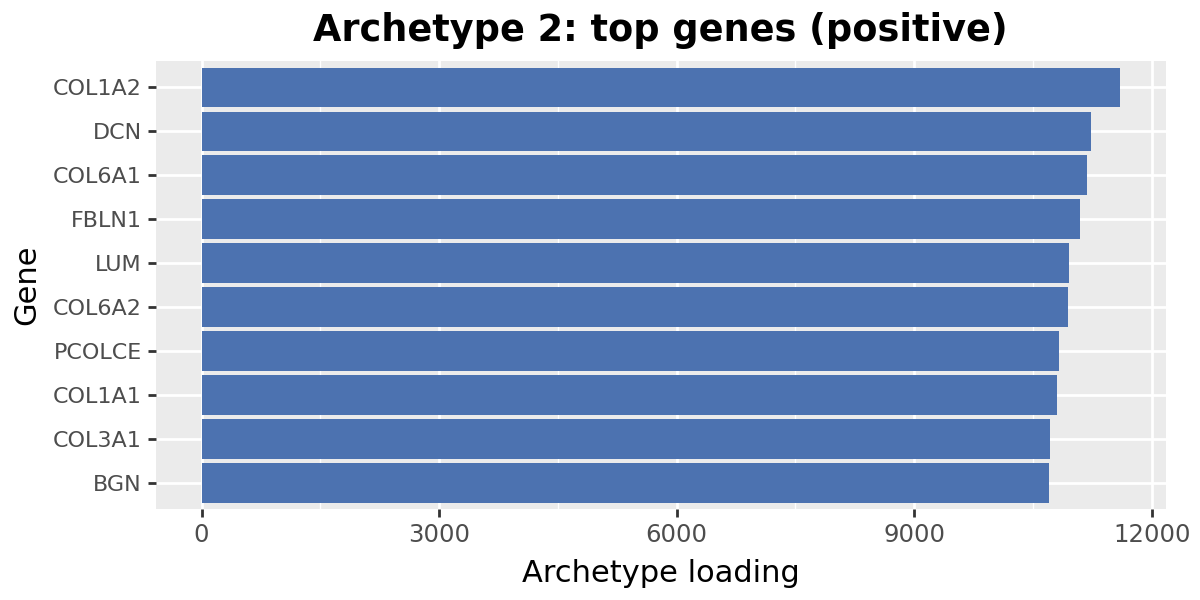

In [101]:
gene_plots[2]

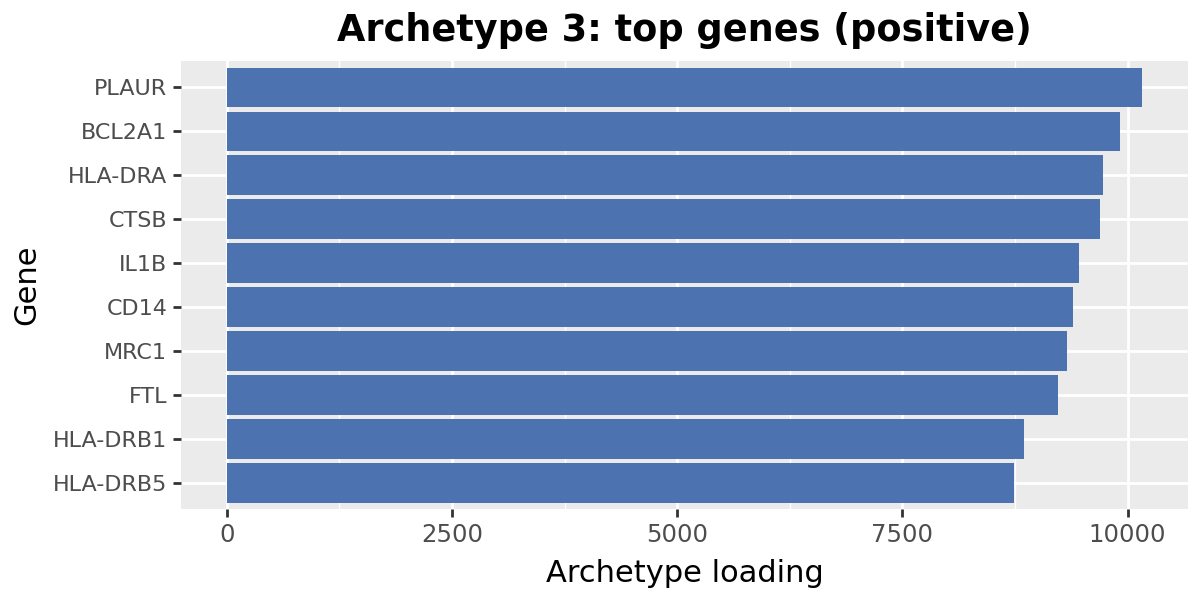

In [102]:
gene_plots[3]

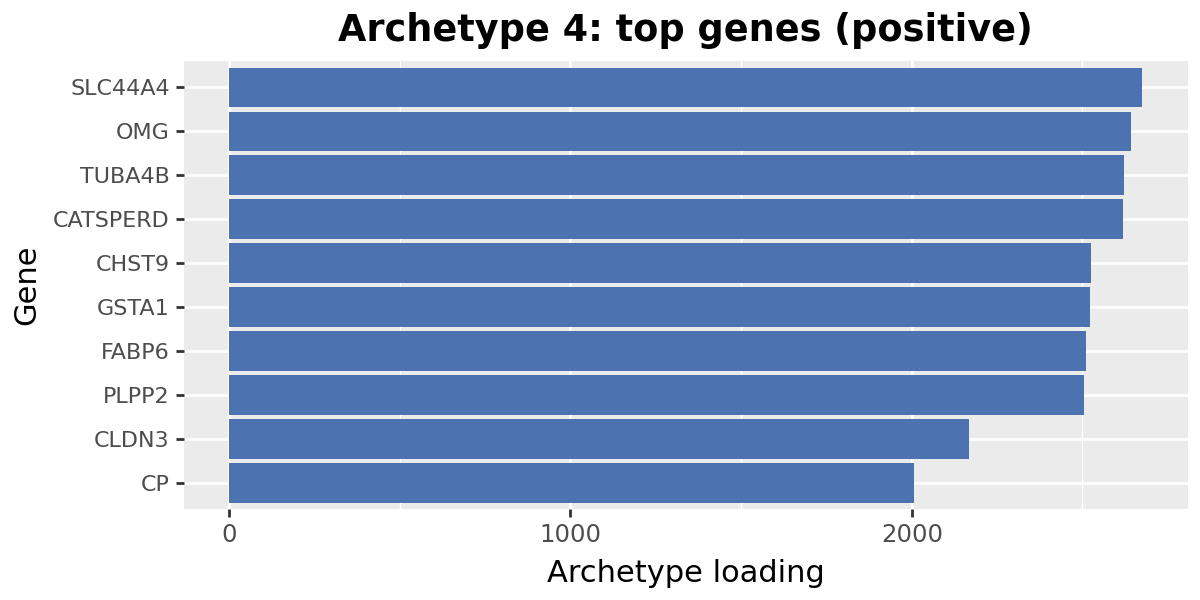

In [103]:
gene_plots[4]

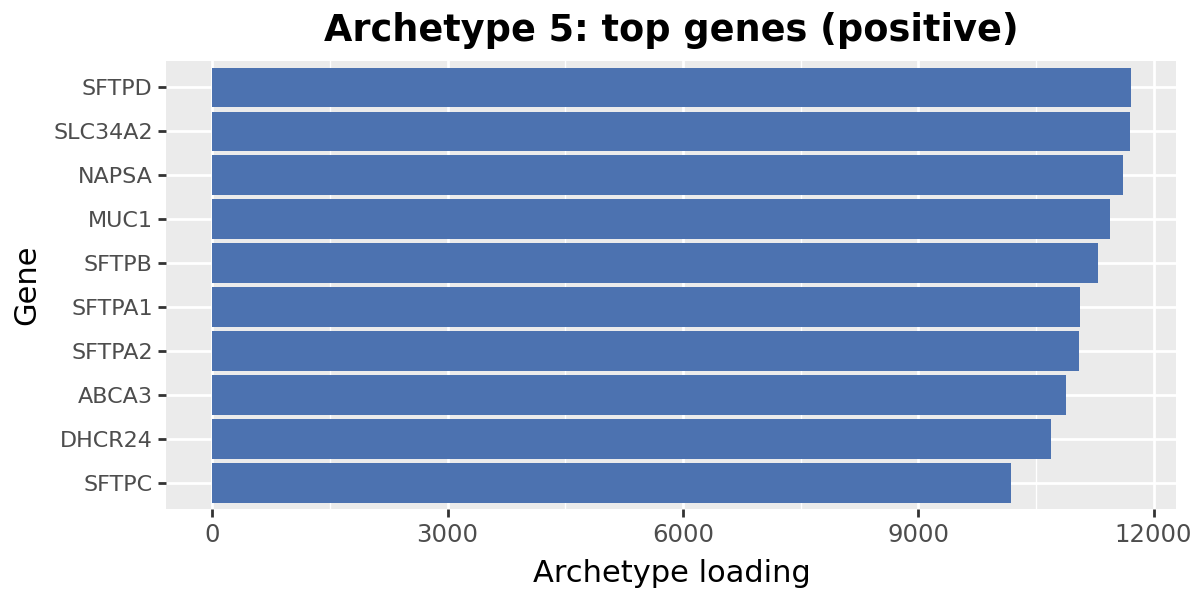

In [104]:
gene_plots[5]

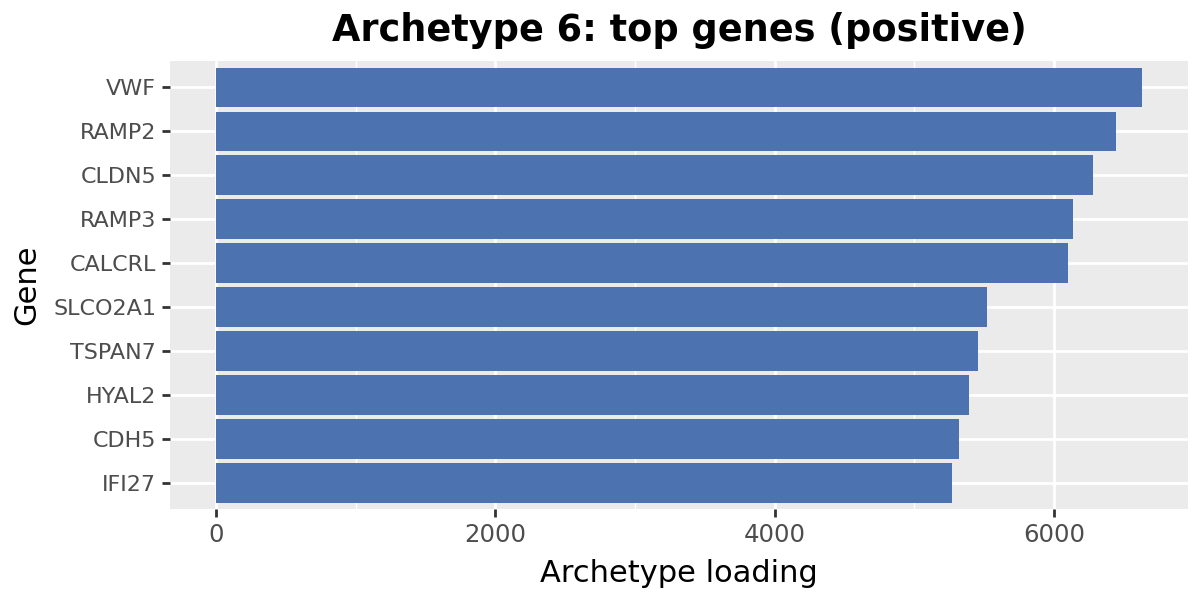

In [105]:
gene_plots[6]